# Chemical Reaction Prediction with Transformers (2025 Edition)

![Molecular Transformer Animation](https://pubs.acs.org/cms/10.1021/acscentsci.9b00576/asset/images/medium/oc9b00576_0009.gif)
<center><b>Figure 1:</b> SMILES-to-SMILES translation with the Molecular Transformer</center>

---

## Course: 06-731 Molecular Machine Learning
**Original lecture by:** Philippe Schwaller (IBM Research / EPFL)  
**Updated for 2025 by:** Gomes Group, Carnegie Mellon University

---

## What's New in This Version?

This notebook is an updated version of the 2022 "Digital Molecular Design Studio" notebook on Chemical Language Models. Key changes include:

| Component | 2022 Version | 2025 Version |
|-----------|--------------|---------------|
| **Framework** | OpenNMT-py 2.2.0 | HuggingFace Transformers (ReactionT5v2) |
| **Model** | Custom Molecular Transformer | Pre-trained ReactionT5v2 |
| **Python** | 3.6-3.8 | 3.10-3.12 |
| **Training** | From scratch (24+ hours) | Fine-tuning (minutes) or inference-only |
| **Atom Mapping** | Not included | RXNMapper integration |
| **API Access** | Not available | rxn4chemistry (IBM RXN) |

### Why the Change?

1. **OpenNMT-py is deprecated** - The project announced it's "no longer actively supported" as of July 2024, with [Eole](https://github.com/eole-nlp/eole) as the successor.
2. **pyonmttok dependency issues** - The tokenizer package fails on Python 3.12 (Google Colab's current version).
3. **Better alternatives exist** - ReactionT5v2 offers state-of-the-art performance with easier setup.

---

## Table of Contents

### Part 1: Setup and Foundations
- [1.1 Environment Setup](#1.1)
- [1.2 SMILES Representation Review](#1.2)
- [1.3 Tokenization for Chemical Language Models](#1.3)

### Part 2: Reaction Prediction with ReactionT5v2
- [2.1 Loading Pre-trained Models](#2.1)
- [2.2 Forward Reaction Prediction](#2.2)
- [2.3 Batch Predictions and Evaluation](#2.3)
- [2.4 Retrosynthesis Prediction](#2.4)

### Part 3: Advanced Topics
- [3.1 Atom Mapping with RXNMapper](#3.1)
- [3.2 IBM RXN for Chemistry API](#3.2)
- [3.3 Data Augmentation for SMILES](#3.3)
- [3.4 Fine-tuning on Custom Datasets](#3.4)

### Part 4: Visualization and Analysis
- [4.1 Drawing Chemical Reactions](#4.1)
- [4.2 Error Analysis and Debugging](#4.2)

### Appendix
- [A. Legacy OpenNMT-py Approach (Reference Only)](#appendix-a)
- [B. Publications and Resources](#appendix-b)

---

## Part 1: Setup and Foundations

<a id='1.1'></a>
### 1.1 Environment Setup

We'll install the necessary packages for this notebook. The installation is designed to work on Google Colab (Python 3.12) and local conda environments.

In [1]:
# Cell 1: Environment Detection and Package Installation
import sys
import subprocess

IN_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IN_COLAB}")
print(f"Python version: {sys.version}")

# Core packages for chemical reaction prediction
PACKAGES = [
    "rdkit",                    # Cheminformatics toolkit
    "torch",                    # PyTorch (usually pre-installed in Colab)
    "transformers>=4.40.0",     # HuggingFace Transformers
    "tokenizers>=0.19.1",       # Fast tokenizers
    "sentencepiece",            # Tokenizer backend
    "accelerate",               # Training acceleration
    "datasets",                 # HuggingFace datasets
    "pandas",                   # Data manipulation
    "gdown",                    # Google Drive downloads
    "tqdm",                     # Progress bars
    "plotly",                   # Interactive visualization
]

def install_packages(packages):
    """Install packages with progress feedback."""
    for pkg in packages:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
    print("\n[SUCCESS] All packages installed!")

if IN_COLAB:
    install_packages(PACKAGES)

Running in Google Colab: True
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Installing rdkit...
Installing torch...
Installing transformers>=4.40.0...
Installing tokenizers>=0.19.1...
Installing sentencepiece...
Installing accelerate...
Installing datasets...
Installing pandas...
Installing gdown...
Installing tqdm...
Installing plotly...

[SUCCESS] All packages installed!


In [2]:
# Cell 2: Import Libraries and Configure Environment
import os
import re
import random
import warnings
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

# RDKit imports
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole
from rdkit import RDLogger

# HuggingFace imports
from transformers import AutoTokenizer, T5ForConditionalGeneration

# Display settings
IPythonConsole.ipython_useSVG = True
RDLogger.DisableLog('rdApp.*')  # Suppress RDKit warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Check GPU availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print(f"\nRDKit version: {Chem.rdBase.rdkitVersion}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB

RDKit version: 2025.09.2
PyTorch version: 2.9.0+cu126


In [3]:
# Cell 3: Gomes Group Color Palette for Visualizations
# Professional styling consistent with Gomes Group publications

GOMES_COLORS = {
    'teal': '#00D9FF',      # Primary accent
    'coral': '#FF6B6B',     # Secondary accent / errors
    'navy': '#0A1628',      # Dark background
    'slate': '#2D3748',     # Text
    'success': '#48BB78',   # Correct predictions
    'warning': '#ECC94B',   # Warnings
    'light_bg': '#F7FAFC',  # Light background
}

# Plotly template for consistent styling
import plotly.graph_objects as go
import plotly.express as px

GOMES_TEMPLATE = go.layout.Template(
    layout=go.Layout(
        font=dict(family="Helvetica Neue, Arial, sans-serif", size=14, color=GOMES_COLORS['slate']),
        plot_bgcolor=GOMES_COLORS['light_bg'],
        paper_bgcolor='white',
        colorway=[GOMES_COLORS['teal'], GOMES_COLORS['coral'], GOMES_COLORS['success'], GOMES_COLORS['warning']],
        title=dict(font=dict(size=20, color=GOMES_COLORS['navy'])),
    )
)

print("Gomes Group styling configured.")

Gomes Group styling configured.


<a id='1.2'></a>
### 1.2 SMILES Representation Review

**SMILES (Simplified Molecular Input Line Entry System)** is a line notation for representing molecules as text strings. For reaction prediction, we treat chemical reactions as a translation problem:

```
Reactants.Reagents >> Products
```

Key concepts:
- **Atoms**: C, N, O, S, etc. (uppercase = aromatic, lowercase = aromatic ring member)
- **Bonds**: Single (implicit or `-`), double (`=`), triple (`#`)
- **Rings**: Numbers indicate ring closures (e.g., `C1CCCCC1` = cyclohexane)
- **Branches**: Parentheses for branching (e.g., `CC(C)C` = isobutane)
- **Stereochemistry**: `@`, `@@` for chirality; `/`, `\` for cis/trans

In [4]:
# Cell 4: SMILES Examples and Canonicalization

def canonicalize_smiles(smiles: str, verbose: bool = False) -> str:
    """
    Convert a SMILES string to its canonical form.

    Canonicalization ensures that the same molecule always has the same SMILES,
    regardless of how it was originally written. This is crucial for:
    1. Comparing predictions to ground truth
    2. Removing duplicates from datasets
    3. Ensuring reproducibility

    Args:
        smiles: Input SMILES string
        verbose: Print warning for invalid SMILES

    Returns:
        Canonical SMILES or empty string if invalid
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return Chem.MolToSmiles(mol)
        else:
            if verbose:
                print(f"Warning: '{smiles}' could not be parsed as a valid molecule.")
            return ''
    except Exception as e:
        if verbose:
            print(f"Error processing '{smiles}': {e}")
        return ''

# Demonstrate canonicalization
examples = [
    ("C(C)O", "Ethanol - different atom ordering"),
    ("OCC", "Ethanol - starting from oxygen"),
    ("CCO", "Ethanol - canonical form"),
    ("c1ccccc1", "Benzene - aromatic notation"),
    ("C1=CC=CC=C1", "Benzene - Kekule notation"),
]

print("SMILES Canonicalization Examples:")
print("-" * 60)
for smiles, description in examples:
    canonical = canonicalize_smiles(smiles)
    print(f"{smiles:20} -> {canonical:20} ({description})")

SMILES Canonicalization Examples:
------------------------------------------------------------
C(C)O                -> CCO                  (Ethanol - different atom ordering)
OCC                  -> CCO                  (Ethanol - starting from oxygen)
CCO                  -> CCO                  (Ethanol - canonical form)
c1ccccc1             -> c1ccccc1             (Benzene - aromatic notation)
C1=CC=CC=C1          -> c1ccccc1             (Benzene - Kekule notation)


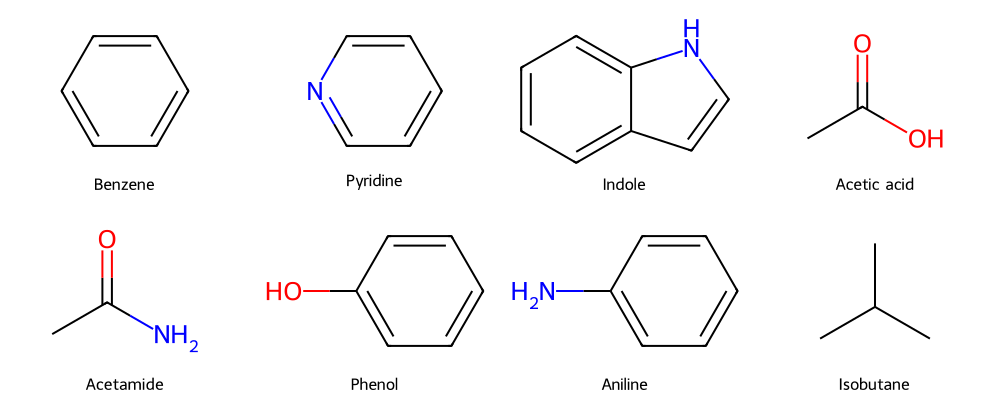

In [5]:
# Cell 5: Visualize molecules from SMILES

def draw_molecules_grid(smiles_list: List[str], labels: Optional[List[str]] = None,
                        mols_per_row: int = 4, img_size: Tuple[int, int] = (250, 200)):
    """
    Draw a grid of molecules from SMILES strings.

    Args:
        smiles_list: List of SMILES strings
        labels: Optional labels for each molecule
        mols_per_row: Number of molecules per row
        img_size: Size of each molecule image

    Returns:
        RDKit grid image
    """
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    if labels is None:
        labels = smiles_list

    return Draw.MolsToGridImage(
        mols,
        molsPerRow=mols_per_row,
        subImgSize=img_size,
        legends=labels
    )

# Example: Common functional groups in drug molecules
drug_motifs = [
    ("c1ccccc1", "Benzene"),
    ("c1ccncc1", "Pyridine"),
    ("c1ccc2[nH]ccc2c1", "Indole"),
    ("CC(=O)O", "Acetic acid"),
    ("CC(=O)N", "Acetamide"),
    ("c1ccc(O)cc1", "Phenol"),
    ("c1ccc(N)cc1", "Aniline"),
    ("CC(C)C", "Isobutane"),
]

smiles_list, labels = zip(*drug_motifs)
draw_molecules_grid(list(smiles_list), list(labels))

<a id='1.3'></a>
### 1.3 Tokenization for Chemical Language Models

Unlike natural language, SMILES requires **atom-wise tokenization** to preserve chemical meaning. We use a regex pattern that recognizes:

- Multi-character elements (Br, Cl)
- Bracketed atoms ([NH2], [Fe+2])
- Ring numbers (including extended %XX notation)
- Stereochemistry markers
- Special symbols (reaction arrow `>>`, etc.)

In [6]:
# Cell 6: SMILES Tokenization

# Regex pattern from the original Molecular Transformer paper
SMI_REGEX_PATTERN = r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def smiles_tokenizer(smiles: str) -> str:
    """
    Tokenize a SMILES string into space-separated tokens.

    This tokenization preserves chemical meaning by keeping:
    - Multi-character elements together (Br, Cl)
    - Bracketed atoms as single tokens ([NH2])
    - Ring numbers as single tokens

    Args:
        smiles: Input SMILES string

    Returns:
        Space-separated tokenized SMILES
    """
    regex = re.compile(SMI_REGEX_PATTERN)
    tokens = regex.findall(smiles)
    return ' '.join(tokens)

def detokenize_smiles(tokenized: str) -> str:
    """Convert tokenized SMILES back to standard SMILES."""
    return tokenized.replace(' ', '')

# Demonstration
test_smiles = [
    "CCO",                                    # Simple: ethanol
    "CC(=O)Oc1ccccc1C(=O)O",                  # Aspirin
    "[NH2]c1ccccc1Br",                        # Bracketed atoms
    "CC.CC>>CCCC",                            # Reaction SMILES
    "C[C@@H](O)CC",                           # Stereochemistry
]

print("SMILES Tokenization Examples:")
print("=" * 70)
for smi in test_smiles:
    tokenized = smiles_tokenizer(smi)
    n_tokens = len(tokenized.split())
    print(f"\nOriginal ({len(smi)} chars):")
    print(f"  {smi}")
    print(f"Tokenized ({n_tokens} tokens):")
    print(f"  {tokenized}")

SMILES Tokenization Examples:

Original (3 chars):
  CCO
Tokenized (3 tokens):
  C C O

Original (21 chars):
  CC(=O)Oc1ccccc1C(=O)O
Tokenized (21 tokens):
  C C ( = O ) O c 1 c c c c c 1 C ( = O ) O

Original (15 chars):
  [NH2]c1ccccc1Br
Tokenized (10 tokens):
  [NH2] c 1 c c c c c 1 Br

Original (11 chars):
  CC.CC>>CCCC
Tokenized (10 tokens):
  C C . C C >> C C C C

Original (12 chars):
  C[C@@H](O)CC
Tokenized (7 tokens):
  C [C@@H] ( O ) C C


---

## Part 2: Reaction Prediction with ReactionT5v2

<a id='2.1'></a>
### 2.1 Loading Pre-trained Models

**ReactionT5v2** is a T5 model pre-trained on the [Open Reaction Database (ORD)](https://github.com/open-reaction-database/ord-data), which contains millions of diverse chemical reactions. Unlike models trained on narrow patent datasets, ReactionT5 offers:

- **Greater generalizability** across reaction types
- **State-of-the-art performance** on standard benchmarks
- **Easy fine-tuning** for specialized applications

Available models on [HuggingFace](https://huggingface.co/collections/sagawa/reactiont5-67dbe0550cbb6886a85e348b):
- `sagawa/ReactionT5v2-forward` - Forward reaction prediction (reactants -> products)
- `sagawa/ReactionT5v2-retrosynthesis` - Retrosynthesis (products -> reactants)
- `sagawa/ReactionT5v2-yield` - Yield prediction

In [7]:
# Cell 7: Load ReactionT5v2 Forward Model

class ReactionT5Predictor:
    """
    Wrapper class for ReactionT5v2 models providing easy-to-use prediction methods.

    This class handles:
    - Model and tokenizer loading
    - Input formatting (REACTANT:...REAGENT:... format)
    - Batch prediction with beam search
    - Output post-processing and validation
    """

    def __init__(self, model_name: str = "sagawa/ReactionT5v2-forward", device: str = None):
        """
        Initialize the predictor with a pre-trained model.

        Args:
            model_name: HuggingFace model identifier
            device: 'cuda' or 'cpu' (auto-detected if None)
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name

        print(f"Loading model: {model_name}")
        print(f"Device: {self.device}")

        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        print(f"Model loaded successfully!")
        print(f"Parameters: {sum(p.numel() for p in self.model.parameters()):,}")

    def format_input(self, reactants: str, reagents: str = " ") -> str:
        """
        Format input for ReactionT5 models.

        Expected format: "REACTANT:{smiles}REAGENT:{smiles}"
        If no reagents, use a space as placeholder.

        Args:
            reactants: SMILES of reactants (concatenated with '.')
            reagents: SMILES of reagents/catalysts/solvents (or ' ')

        Returns:
            Formatted input string
        """
        return f"REACTANT:{reactants}REAGENT:{reagents}"

    def predict(self, reactants: str, reagents: str = " ",
                num_beams: int = 5, num_return_sequences: int = 5,
                max_length: int = 200) -> List[Dict]:
        """
        Predict products for a single reaction.

        Args:
            reactants: SMILES of reactants
            reagents: SMILES of reagents (default: ' ' for none)
            num_beams: Beam search width
            num_return_sequences: Number of predictions to return
            max_length: Maximum output sequence length

        Returns:
            List of dicts with 'smiles', 'canonical', 'valid', 'score' keys
        """
        # Format and tokenize input
        input_text = self.format_input(reactants, reagents)
        inputs = self.tokenizer(input_text, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Generate predictions
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                num_beams=num_beams,
                num_return_sequences=num_return_sequences,
                max_length=max_length,
                return_dict_in_generate=True,
                output_scores=True,
            )

        # Decode and validate predictions
        results = []
        for seq in outputs.sequences:
            pred_smiles = self.tokenizer.decode(seq, skip_special_tokens=True)
            pred_smiles = pred_smiles.replace(' ', '').rstrip('.')
            canonical = canonicalize_smiles(pred_smiles)

            results.append({
                'smiles': pred_smiles,
                'canonical': canonical,
                'valid': canonical != '',
            })

        return results

    def predict_batch(self, reactions: List[Dict], batch_size: int = 16,
                      num_beams: int = 5, num_return_sequences: int = 5) -> List[List[Dict]]:
        """
        Batch prediction for multiple reactions.

        Args:
            reactions: List of dicts with 'reactants' and optionally 'reagents' keys
            batch_size: Batch size for inference
            num_beams: Beam search width
            num_return_sequences: Predictions per reaction

        Returns:
            List of prediction lists (one per input reaction)
        """
        all_results = []

        for i in tqdm(range(0, len(reactions), batch_size), desc="Predicting"):
            batch = reactions[i:i+batch_size]

            # Format inputs
            input_texts = [
                self.format_input(r['reactants'], r.get('reagents', ' '))
                for r in batch
            ]

            inputs = self.tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    num_beams=num_beams,
                    num_return_sequences=num_return_sequences,
                    max_length=200,
                )

            # Decode outputs
            decoded = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

            # Group by input reaction
            for j in range(len(batch)):
                start_idx = j * num_return_sequences
                end_idx = start_idx + num_return_sequences

                preds = []
                for pred in decoded[start_idx:end_idx]:
                    pred = pred.replace(' ', '').rstrip('.')
                    canonical = canonicalize_smiles(pred)
                    preds.append({
                        'smiles': pred,
                        'canonical': canonical,
                        'valid': canonical != '',
                    })
                all_results.append(preds)

        return all_results

# Initialize the predictor
print("Initializing ReactionT5v2 Forward Predictor...")
print("(This may take a moment to download the model)")
print()

forward_predictor = ReactionT5Predictor("sagawa/ReactionT5v2-forward", device=DEVICE)

Initializing ReactionT5v2 Forward Predictor...
(This may take a moment to download the model)

Loading model: sagawa/ReactionT5v2-forward
Device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/795M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

Model loaded successfully!
Parameters: 198,640,896


<a id='2.2'></a>
### 2.2 Forward Reaction Prediction

Let's test the model on some example reactions. We'll predict products from reactants and reagents.

In [8]:
# Cell 8: Single Reaction Prediction Examples

# Example reactions with known products
test_reactions = [
    {
        "name": "Esterification (Fischer)",
        "reactants": "CC(=O)O.CCO",  # Acetic acid + Ethanol
        "reagents": " ",  # Acid catalyst (implicit)
        "expected": "CCOC(C)=O",  # Ethyl acetate
    },
    {
        "name": "Suzuki Coupling",
        "reactants": "Brc1ccccc1.OB(O)c1ccccc1",  # Bromobenzene + Phenylboronic acid
        "reagents": "[Pd]",  # Palladium catalyst
        "expected": "c1ccc(-c2ccccc2)cc1",  # Biphenyl
    },
    {
        "name": "Amide Formation",
        "reactants": "CC(=O)O.NCC",  # Acetic acid + Ethylamine
        "reagents": " ",
        "expected": "CCNC(C)=O",  # N-ethylacetamide
    },
    {
        "name": "Grignard Addition",
        "reactants": "CC=O.[Mg]Br",  # Acetaldehyde + MgBr
        "reagents": "CCCC",  # Butyl (as Grignard)
        "expected": "CCCCC(C)O",  # 2-hexanol
    },
]

print("Forward Reaction Prediction Examples")
print("=" * 70)

for rxn in test_reactions:
    print(f"\n{rxn['name']}")
    print("-" * 50)
    print(f"Reactants: {rxn['reactants']}")
    print(f"Reagents:  {rxn['reagents']}")
    print(f"Expected:  {rxn['expected']}")

    # Get predictions
    predictions = forward_predictor.predict(
        rxn['reactants'],
        rxn['reagents'],
        num_beams=5,
        num_return_sequences=3
    )

    print("\nPredictions:")
    expected_canonical = canonicalize_smiles(rxn['expected'])

    for i, pred in enumerate(predictions, 1):
        status = "[CORRECT]" if pred['canonical'] == expected_canonical else ""
        valid = "valid" if pred['valid'] else "INVALID"
        print(f"  {i}. {pred['canonical']:40} ({valid}) {status}")

Forward Reaction Prediction Examples

Esterification (Fischer)
--------------------------------------------------
Reactants: CC(=O)O.CCO
Reagents:   
Expected:  CCOC(C)=O

Predictions:
  1. CC(O)C(C)O                               (valid) 
  2. CC(O)C(C)(C)C(=O)O                       (valid) 
  3. CC(O)C(C)(C)CC(=O)O                      (valid) 

Suzuki Coupling
--------------------------------------------------
Reactants: Brc1ccccc1.OB(O)c1ccccc1
Reagents:  [Pd]
Expected:  c1ccc(-c2ccccc2)cc1

Predictions:
  1. c1ccc(-c2ccccc2)cc1                      (valid) [CORRECT]
  2. c1ccc(-c2ccccc2)cc1.c1ccc(-c2ccccc2)cc1  (valid) 
  3. c1ccc(-c2ccccc2-c2ccccc2)cc1             (valid) 

Amide Formation
--------------------------------------------------
Reactants: CC(=O)O.NCC
Reagents:   
Expected:  CCNC(C)=O

Predictions:
  1. CC(=O)O.CCNCC                            (valid) 
  2. CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CCN.CC[NH3+].[NH4+].[NH4+] (valid) 
  3. CC(=O)[O-].CC(=O)[O-].CC[NH3+].[NH3+] 

Reaction: Esterification (Fischer)
Input: CC(=O)O.CCO
Predicted Product: CC(O)C(C)O
Expected Product: CCOC(C)=O


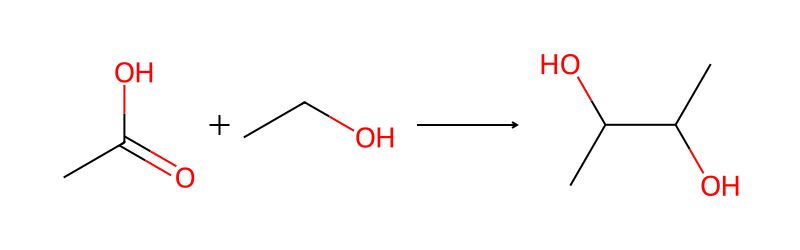

In [9]:
# Cell 9: Visualize a Predicted Reaction
from IPython.display import SVG, display, HTML

def draw_chemical_reaction(rxn_smiles: str, highlight_by_reactant: bool = True,
                           use_smiles: bool = True, width: int = 800, height: int = 250) -> str:
    """
    Draw a chemical reaction from SMILES.

    Args:
        rxn_smiles: Reaction SMILES (format: reactants>>products)
        highlight_by_reactant: Color atoms by which reactant they came from
        use_smiles: Parse as SMILES (True) or SMARTS (False)
        width: Image width
        height: Image height

    Returns:
        SVG string of the reaction drawing
    """
    try:
        rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=use_smiles)
        d2d = rdMolDraw2D.MolDraw2DSVG(width, height)
        d2d.drawOptions().annotationFontScale = 1.2
        d2d.DrawReaction(rxn, highlightByReactant=highlight_by_reactant)
        d2d.FinishDrawing()
        return d2d.GetDrawingText()
    except Exception as e:
        return f"<p>Error drawing reaction: {e}</p>"

# Draw the first test reaction with its prediction
rxn = test_reactions[0]
predictions = forward_predictor.predict(rxn['reactants'], rxn['reagents'], num_return_sequences=1)
pred_smiles = predictions[0]['canonical']

print(f"Reaction: {rxn['name']}")
print(f"Input: {rxn['reactants']}")
print(f"Predicted Product: {pred_smiles}")
print(f"Expected Product: {rxn['expected']}")

rxn_smiles = f"{rxn['reactants']}>>{pred_smiles}"
display(SVG(draw_chemical_reaction(rxn_smiles)))

<a id='2.3'></a>
### 2.3 Batch Predictions and Evaluation

Now let's evaluate the model on a larger dataset. We'll download a subset of the USPTO dataset and compute standard metrics (Top-1, Top-3, Top-5 accuracy).

In [10]:
# Cell 10: Download USPTO Dataset Subset
import gdown

def download_uspto_data(data_dir: str = "USPTO_480k") -> None:
    """
    Download USPTO 480k reaction dataset.

    This dataset contains ~480,000 reactions from US patents,
    split into train/val/test sets.
    """
    os.makedirs(data_dir, exist_ok=True)

    # Google Drive links for USPTO_480k
    files = [
        ("https://drive.google.com/uc?id=1RysNBvB2rsMP0Ap9XXi02XiiZkEXCrA8", "src-train.txt"),
        ("https://drive.google.com/uc?id=1CxxcVqtmOmHE2nhmqPFA6bilavzpcIlb", "tgt-train.txt"),
        ("https://drive.google.com/uc?id=1FFN1nz2yB4VwrpWaBuiBDzFzdX3ONBsy", "src-val.txt"),
        ("https://drive.google.com/uc?id=1pYCjWkYvgp1ZQ78EKQBArOvt_2P1KnmI", "tgt-val.txt"),
        ("https://drive.google.com/uc?id=10t6pHj9yR8Tp3kDvG0KMHl7Bt_TUbQ8W", "src-test.txt"),
        ("https://drive.google.com/uc?id=1FeGuiGuz0chVBRgePMu0pGJA4FVReA-b", "tgt-test.txt"),
    ]

    for url, filename in files:
        target = os.path.join(data_dir, filename)
        if not os.path.exists(target):
            print(f"Downloading {filename}...")
            gdown.download(url, target, quiet=False)
        else:
            print(f"{filename} already exists.")

def load_uspto_data(data_dir: str = "USPTO_480k", split: str = "val",
                    max_samples: int = None) -> pd.DataFrame:
    """
    Load USPTO dataset into a DataFrame.

    Args:
        data_dir: Directory containing the data files
        split: 'train', 'val', or 'test'
        max_samples: Maximum number of samples to load (None for all)

    Returns:
        DataFrame with 'precursors' and 'products' columns
    """
    src_file = os.path.join(data_dir, f"src-{split}.txt")
    tgt_file = os.path.join(data_dir, f"tgt-{split}.txt")

    with open(src_file, 'r') as f:
        precursors = [line.strip().replace(' ', '') for line in f]
    with open(tgt_file, 'r') as f:
        products = [line.strip().replace(' ', '') for line in f]

    df = pd.DataFrame({'precursors': precursors, 'products': products})

    if max_samples:
        df = df.head(max_samples)

    return df

# Download and load data
print("Downloading USPTO 480k dataset...")
download_uspto_data()

# For demonstration, we'll use a smaller subset
N_EVAL_SAMPLES = 100  # Use 100 samples for quick evaluation
val_df = load_uspto_data(split="val", max_samples=N_EVAL_SAMPLES)

print(f"\nLoaded {len(val_df)} validation reactions")
print("\nSample reactions:")
val_df.head()

Downloading...
From: https://drive.google.com/uc?id=1RysNBvB2rsMP0Ap9XXi02XiiZkEXCrA8
To: /content/USPTO_480k/src-train.txt
100%|██████████| 57.4M/57.4M [00:00<00:00, 108MB/s]


Downloading...
From: https://drive.google.com/uc?id=1CxxcVqtmOmHE2nhmqPFA6bilavzpcIlb
To: /content/USPTO_480k/tgt-train.txt
100%|██████████| 33.8M/33.8M [00:00<00:00, 88.9MB/s]


Downloading...
From: https://drive.google.com/uc?id=1FFN1nz2yB4VwrpWaBuiBDzFzdX3ONBsy
To: /content/USPTO_480k/src-val.txt
100%|██████████| 4.21M/4.21M [00:00<00:00, 28.3MB/s]


Downloading...
From: https://drive.google.com/uc?id=1pYCjWkYvgp1ZQ78EKQBArOvt_2P1KnmI
To: /content/USPTO_480k/tgt-val.txt
100%|██████████| 2.47M/2.47M [00:00<00:00, 19.6MB/s]


Downloading...
From: https://drive.google.com/uc?id=10t6pHj9yR8Tp3kDvG0KMHl7Bt_TUbQ8W
To: /content/USPTO_480k/src-test.txt
100%|██████████| 5.64M/5.64M [00:00<00:00, 36.0MB/s]


Downloading...
From: https://drive.google.com/uc?id=1FeGuiGuz0chVBRgePMu0pGJA4FVReA-b
To: /content/USPTO_480k/tgt-test.txt
100%|██████████| 3.30M/3.30M [00:00<00:00, 21.5MB/s]



Loaded 100 validation reactions

Sample reactions:


,precursors,products
0,CC(C)=O.COc1ccc(S(=O)(=O)Cl)cc1.[I-].[Na+],COc1ccc(S(=O)[O-])cc1
1,CC(C)(C)[O-].N#Cc1c(N)nc(Cl)c(C#N)c1-c1ccccc1....,N#Cc1c(N)nc(OCc2ccccn2)c(C#N)c1-c1ccccc1
2,C1CCOC1.CCCCCCC.CN1CCC(CCO)CC1.Cc1ccc(N2CCN(C(...,Cc1ccc(N2CCN(C(=O)OCCC3CCN(C)CC3)CC2)cc1
3,CC(C)(C)OC(=O)N1CCC(COC(=O)C2CCC3CN2C(=O)N3OS(...,O=C(OCC1CCNCC1)C1CCC2CN1C(=O)N2OS(=O)(=O)O
4,CCC12CCC3C4CCC(=O)C=C4CCC3C1C(O)CC2=O.ClCCl.O....,CCC12CCC3C4CCC(=O)C=C4CCC3C1C(OC(=O)c1ccccc1)C...


In [11]:
# Cell 11: Evaluate Model on USPTO Validation Set

def evaluate_predictions(df: pd.DataFrame, predictor: ReactionT5Predictor,
                        n_best: int = 5, batch_size: int = 16) -> pd.DataFrame:
    """
    Evaluate model predictions against ground truth.

    Args:
        df: DataFrame with 'precursors' and 'products' columns
        predictor: ReactionT5Predictor instance
        n_best: Number of predictions per reaction
        batch_size: Batch size for inference

    Returns:
        DataFrame with predictions and evaluation metrics
    """
    # Prepare reactions for batch prediction
    reactions = [{'reactants': row['precursors'], 'reagents': ' '}
                 for _, row in df.iterrows()]

    # Get predictions
    all_predictions = predictor.predict_batch(
        reactions,
        batch_size=batch_size,
        num_beams=n_best,
        num_return_sequences=n_best
    )

    # Add predictions to DataFrame
    results = df.copy()
    results['target_canonical'] = results['products'].apply(canonicalize_smiles)

    # Store predictions
    for i in range(n_best):
        results[f'pred_{i+1}'] = [preds[i]['canonical'] if i < len(preds) else ''
                                   for preds in all_predictions]
        results[f'pred_{i+1}_valid'] = [preds[i]['valid'] if i < len(preds) else False
                                         for preds in all_predictions]

    # Calculate rank of correct prediction
    def get_rank(row):
        target = row['target_canonical']
        for i in range(1, n_best + 1):
            if row[f'pred_{i}'] == target:
                return i
        return 0  # Not found

    results['rank'] = results.apply(get_rank, axis=1)

    return results

# Run evaluation (this may take a few minutes)
print(f"Evaluating on {len(val_df)} reactions...")
print("(This may take a few minutes)")

eval_results = evaluate_predictions(val_df, forward_predictor, n_best=5, batch_size=8)

# Calculate metrics
n_total = len(eval_results)
print("\n" + "=" * 50)
print("EVALUATION RESULTS")
print("=" * 50)

for k in [1, 2, 3, 5]:
    correct = (eval_results['rank'] > 0) & (eval_results['rank'] <= k)
    accuracy = correct.sum() / n_total * 100
    print(f"Top-{k} Accuracy: {accuracy:.1f}%")

# Invalid SMILES rate
invalid_rate = (~eval_results['pred_1_valid']).sum() / n_total * 100
print(f"\nInvalid Top-1 SMILES: {invalid_rate:.1f}%")

Evaluating on 100 reactions...
(This may take a few minutes)


Predicting:   0%|          | 0/13 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



EVALUATION RESULTS
Top-1 Accuracy: 95.0%
Top-2 Accuracy: 95.0%
Top-3 Accuracy: 97.0%
Top-5 Accuracy: 97.0%

Invalid Top-1 SMILES: 0.0%


In [12]:
# Cell 12: Visualize Evaluation Results

# Create accuracy bar chart
accuracies = []
for k in [1, 2, 3, 4, 5]:
    correct = (eval_results['rank'] > 0) & (eval_results['rank'] <= k)
    accuracy = correct.sum() / len(eval_results) * 100
    accuracies.append({'k': f'Top-{k}', 'accuracy': accuracy})

acc_df = pd.DataFrame(accuracies)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=acc_df['k'],
    y=acc_df['accuracy'],
    marker_color=GOMES_COLORS['teal'],
    text=[f"{a:.1f}%" for a in acc_df['accuracy']],
    textposition='outside'
))

fig.update_layout(
    template=GOMES_TEMPLATE,
    title='ReactionT5v2 Accuracy on USPTO Validation Set',
    xaxis_title='',
    yaxis_title='Accuracy (%)',
    yaxis_range=[0, 100],
    showlegend=False,
    height=400,
)

fig.show()

<a id='2.4'></a>
### 2.4 Retrosynthesis Prediction

Retrosynthesis is the reverse problem: given a target product, predict the reactants needed to synthesize it. This is crucial for drug discovery and chemical manufacturing.

ReactionT5v2 also provides a retrosynthesis model.

In [13]:
# Cell 13: Retrosynthesis Predictor

class RetrosynthesisPredictor:
    """
    Wrapper for ReactionT5v2 retrosynthesis model.

    Given a target product, predicts possible reactants.
    """

    def __init__(self, model_name: str = "sagawa/ReactionT5v2-retrosynthesis", device: str = None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name

        print(f"Loading retrosynthesis model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
        print("Model loaded!")

    def predict(self, product: str, num_beams: int = 10,
                num_return_sequences: int = 5) -> List[Dict]:
        """
        Predict reactants for a target product.

        Args:
            product: SMILES of target product
            num_beams: Beam search width
            num_return_sequences: Number of predictions

        Returns:
            List of predicted reactant sets
        """
        input_text = f"PRODUCT:{product}"
        inputs = self.tokenizer(input_text, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                num_beams=num_beams,
                num_return_sequences=num_return_sequences,
                max_length=200,
            )

        results = []
        for seq in outputs:
            pred = self.tokenizer.decode(seq, skip_special_tokens=True)
            pred = pred.replace(' ', '').rstrip('.')

            # Validate each reactant
            reactants = pred.split('.')
            valid = all(canonicalize_smiles(r) != '' for r in reactants if r)

            results.append({
                'reactants': pred,
                'valid': valid,
            })

        return results

# Load retrosynthesis model
print("Loading retrosynthesis model...")
retro_predictor = RetrosynthesisPredictor(device=DEVICE)

Loading retrosynthesis model...
Loading retrosynthesis model: sagawa/ReactionT5v2-retrosynthesis


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/795M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

Model loaded!


Retrosynthesis Predictions

Target: Aspirin
SMILES: CC(=O)Oc1ccccc1C(=O)O


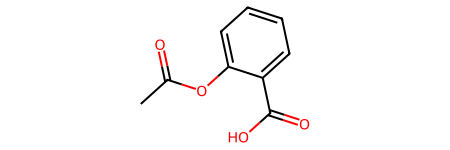


Predicted Reactants:
  1. CCN(CC)CC.Cc1ccc(S(=O)(=O)[O-])cc1.O=C(O)c1ccccc1O.O=P12OP3(=O)OP(=O)(O1)OP(=O)(O2)O3.c1cc[nH+]cc1 (valid)
  2. CCN(CC)CC.O=C(O)c1ccccc1O.O=P12OP3(=O)OP(=O)(O1)OP(=O)(O2)O3 (valid)
  3. CCN(CC)CC.Cc1ccc(S(=O)(=O)[O-])cc1.O=C(O)c1ccccc1O.O=P12OP3(=O)OP(=O)(O1)OP(=O)(O2)O3.c1ccncc1 (valid)


Target: Ibuprofen
SMILES: CC(C)Cc1ccc(C(C)C(=O)O)cc1


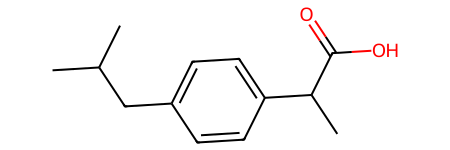


Predicted Reactants:
  1. CC1Cc2ccc(C(C)C(=O)O)cc2C(c2ccc(N)cc2)C1.CC1Cc2ccc(C(C)C(=O)O)cc2C(c2ccc(N)cc2)C1.F[B-](F)(F)F.O=N[O-].[H+].[Na+] (valid)
  2. CC1Cc2ccc(C(C)C(=O)O)cc2C(c2ccc(N)cc2)C1.F[B-](F)(F)F.O=N[O-].[H+].[Na+] (valid)
  3. CC1Cc2ccc(C(C)C(=O)O)cc2C(c2ccc(N)cc2)C1.CC1Cc2ccc(C(C)C(=O)O)cc2C(c2ccc(N)cc2)C1.F[B-](F)(F)F.O=N[O-].O=N[O-].[H+].[Na+].[Na+] (valid)


Target: Ethyl Acetate
SMILES: CCOC(C)=O


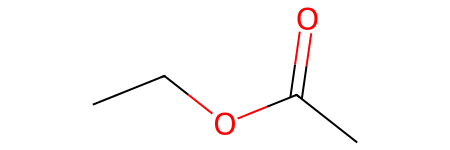


Predicted Reactants:
  1. CC(=O)OC(C)=O.CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[ (INVALID)
  2. CC(=O)OC(C)=O.CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)O (valid)
  3. CC(=O)OC(C)=O.CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].Cc1ccccc1 (valid)



In [14]:
# Cell 14: Retrosynthesis Examples

# Target molecules for retrosynthesis
targets = [
    {
        "name": "Aspirin",
        "smiles": "CC(=O)Oc1ccccc1C(=O)O",
    },
    {
        "name": "Ibuprofen",
        "smiles": "CC(C)Cc1ccc(C(C)C(=O)O)cc1",
    },
    {
        "name": "Ethyl Acetate",
        "smiles": "CCOC(C)=O",
    },
]

print("Retrosynthesis Predictions")
print("=" * 70)

for target in targets:
    print(f"\nTarget: {target['name']}")
    print(f"SMILES: {target['smiles']}")

    # Show target molecule
    mol = Chem.MolFromSmiles(target['smiles'])
    display(mol)

    # Get retrosynthesis predictions
    predictions = retro_predictor.predict(target['smiles'], num_return_sequences=3)

    print("\nPredicted Reactants:")
    for i, pred in enumerate(predictions, 1):
        valid_str = "valid" if pred['valid'] else "INVALID"
        print(f"  {i}. {pred['reactants']} ({valid_str})")
    print()

---

## Part 3: Advanced Topics

<a id='3.1'></a>
### 3.1 Atom Mapping with RXNMapper

Atom mapping shows which atoms in the reactants correspond to which atoms in the products. This is crucial for understanding reaction mechanisms.

[RXNMapper](https://github.com/rxn4chemistry/rxnmapper) uses transformer attention to learn atom correspondences without supervision.

In [15]:
# Cell 15: Install and Setup RXNMapper

# RXNMapper installation (may require specific handling for Colab)
try:
    from rxnmapper import RXNMapper
    RXNMAPPER_AVAILABLE = True
    print("RXNMapper is available!")
except ImportError:
    print("Installing RXNMapper...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "rxnmapper"])

    try:
        from rxnmapper import RXNMapper
        RXNMAPPER_AVAILABLE = True
        print("RXNMapper installed successfully!")
    except ImportError as e:
        RXNMAPPER_AVAILABLE = False
        print(f"RXNMapper installation failed: {e}")
        print("This is optional - the notebook will continue without atom mapping.")

Installing RXNMapper...
RXNMapper installed successfully!


Atom Mapping Examples

Reaction: CC(=O)O.CCO>>CCOC(C)=O.O
Mapped:   [C:4]([CH3:5])(=[O:6])[OH:7].[CH3:1][CH2:2][OH:3]>>[CH3:1][CH2:2][O:3][C:4]([CH3:5])=[O:6].[OH2:7]
Confidence: 0.827


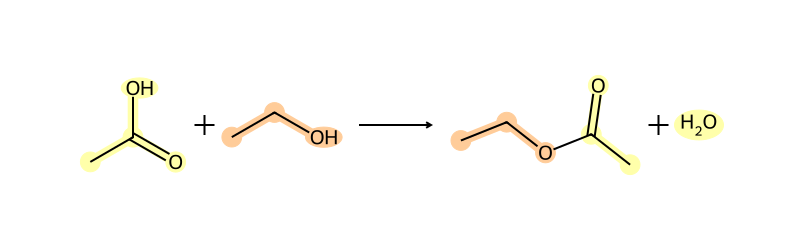


Reaction: Brc1ccccc1.OB(O)c1ccccc1>>c1ccc(-c2ccccc2)cc1
Mapped:   Br[c:5]1[cH:6][cH:7][cH:8][cH:9][cH:10]1.OB(O)[c:4]1[cH:3][cH:2][cH:1][cH:12][cH:11]1>>[cH:1]1[cH:2][cH:3][c:4](-[c:5]2[cH:6][cH:7][cH:8][cH:9][cH:10]2)[cH:11][cH:12]1
Confidence: 0.415


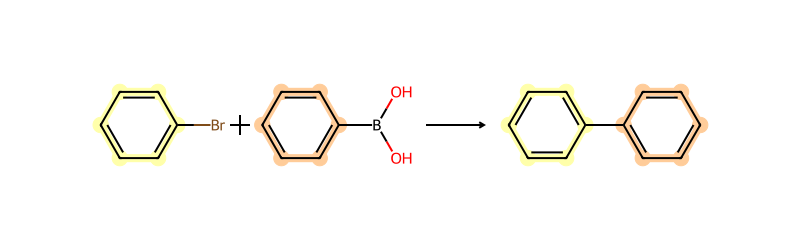


Reaction: c1ccccc1.Cl>>Clc1ccccc1
Mapped:   [ClH:1].[cH:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1>>[Cl:1][c:2]1[cH:3][cH:4][cH:5][cH:6][cH:7]1
Confidence: 0.455


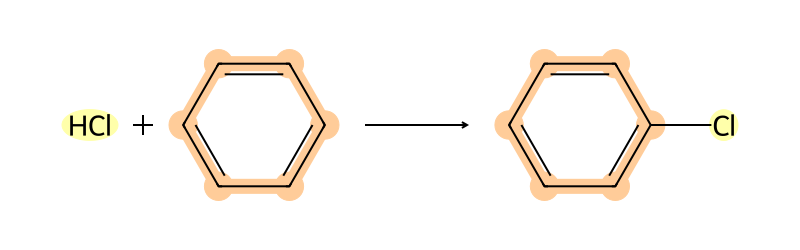

In [16]:
# Cell 16: Atom Mapping Examples

if RXNMAPPER_AVAILABLE:
    # Initialize RXNMapper
    rxn_mapper = RXNMapper()

    # Example reactions for atom mapping
    reactions_to_map = [
        "CC(=O)O.CCO>>CCOC(C)=O.O",  # Esterification
        "Brc1ccccc1.OB(O)c1ccccc1>>c1ccc(-c2ccccc2)cc1",  # Suzuki coupling
        "c1ccccc1.Cl>>Clc1ccccc1",  # Chlorination
    ]

    print("Atom Mapping Examples")
    print("=" * 70)

    for rxn in reactions_to_map:
        print(f"\nReaction: {rxn}")

        # Get atom mapping
        result = rxn_mapper.get_attention_guided_atom_maps([rxn])[0]
        mapped_rxn = result['mapped_rxn']
        confidence = result['confidence']

        print(f"Mapped:   {mapped_rxn}")
        print(f"Confidence: {confidence:.3f}")

        # Draw the mapped reaction
        try:
            display(SVG(draw_chemical_reaction(mapped_rxn, use_smiles=True)))
        except:
            print("(Could not render reaction image)")
else:
    print("RXNMapper not available. Skipping atom mapping examples.")
    print("You can still use the model for reaction prediction.")

<a id='3.2'></a>
### 3.2 IBM RXN for Chemistry API

[IBM RXN for Chemistry](https://rxn.res.ibm.com) provides access to production-grade reaction prediction models through a REST API. This is useful for:

- Access to models trained on larger datasets
- Production applications
- No local GPU required

**Note:** You need a free API key from [rxn.res.ibm.com](https://rxn.res.ibm.com).

In [17]:
# Cell 17: IBM RXN for Chemistry Setup (Optional)

# Install rxn4chemistry client
try:
    from rxn4chemistry import RXN4ChemistryWrapper
    RXN4CHEM_AVAILABLE = True
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "rxn4chemistry"])
    try:
        from rxn4chemistry import RXN4ChemistryWrapper
        RXN4CHEM_AVAILABLE = True
    except:
        RXN4CHEM_AVAILABLE = False

if RXN4CHEM_AVAILABLE:
    print("rxn4chemistry is available!")
    print("")
    print("To use IBM RXN for Chemistry:")
    print("1. Create a free account at https://rxn.res.ibm.com")
    print("2. Get your API key from your profile settings")
    print("3. Set it below:")
    print("")
    print("# Example usage:")
    print("# api_key = 'YOUR_API_KEY_HERE'")
    print("# rxn = RXN4ChemistryWrapper(api_key=api_key)")
    print("# rxn.create_project('my_project')")
    print("# rxn.predict_reaction('BrBr.c1ccc2cc3ccccc3cc2c1')")
else:
    print("rxn4chemistry not available.")

rxn4chemistry is available!

To use IBM RXN for Chemistry:
1. Create a free account at https://rxn.res.ibm.com
2. Get your API key from your profile settings
3. Set it below:

# Example usage:
# api_key = 'YOUR_API_KEY_HERE'
# rxn = RXN4ChemistryWrapper(api_key=api_key)
# rxn.create_project('my_project')
# rxn.predict_reaction('BrBr.c1ccc2cc3ccccc3cc2c1')


In [18]:
# Cell 18: IBM RXN API Example (requires API key)

# Uncomment and fill in your API key to use
USE_IBM_RXN = False  # Set to True if you have an API key

if USE_IBM_RXN and RXN4CHEM_AVAILABLE:
    # Replace with your actual API key
    api_key = "YOUR_API_KEY_HERE"

    rxn = RXN4ChemistryWrapper(api_key=api_key)
    rxn.create_project('reaction_prediction_demo')

    # Predict a reaction
    reactants = "CC(=O)O.CCO"  # Acetic acid + Ethanol
    result = rxn.predict_reaction(reactants)

    print(f"Input: {reactants}")
    print(f"Predicted products: {result}")
else:
    print("IBM RXN API demo skipped.")
    print("Set USE_IBM_RXN = True and provide your API key to test.")

IBM RXN API demo skipped.
Set USE_IBM_RXN = True and provide your API key to test.


<a id='3.3'></a>
### 3.3 Data Augmentation for SMILES

A key technique for improving chemical language models is **SMILES randomization**. Since the same molecule can be written as many different valid SMILES strings, we can augment training data by generating alternative representations.

This teaches the model that different SMILES can represent the same molecule, improving generalization.

In [19]:
# Cell 19: SMILES Randomization Functions

def randomize_smiles(smiles: str, random_type: str = "rotated") -> Optional[str]:
    """
    Generate a random but equivalent SMILES representation.

    Three randomization strategies:
    - 'rotated': Change the starting atom (preserves ring-opening order)
    - 'restricted': Shuffle atom order with some constraints
    - 'unrestricted': Full random atom ordering

    Args:
        smiles: Input canonical SMILES
        random_type: Randomization strategy

    Returns:
        Randomized SMILES or None if invalid
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    if random_type == "unrestricted":
        # Full random SMILES (most diverse)
        return Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=True)

    elif random_type == "restricted":
        # Random atom order with some constraints
        new_atom_order = list(range(mol.GetNumAtoms()))
        random.shuffle(new_atom_order)
        random_mol = Chem.RenumberAtoms(mol, newOrder=new_atom_order)
        return Chem.MolToSmiles(random_mol, canonical=False, isomericSmiles=True)

    elif random_type == "rotated":
        # Rotate starting atom (least disruptive)
        n_atoms = mol.GetNumAtoms()
        rotation_index = random.randint(0, n_atoms - 1)
        atoms = list(range(n_atoms))
        new_order = atoms[rotation_index:] + atoms[:rotation_index]
        rotated_mol = Chem.RenumberAtoms(mol, new_order)
        return Chem.MolToSmiles(rotated_mol, canonical=False, isomericSmiles=True)

    raise ValueError(f"Unknown random_type: {random_type}")

# Demonstrate SMILES randomization
caffeine = "Cn1cnc2c1c(=O)n(c(=O)n2C)C"  # Caffeine
canonical = canonicalize_smiles(caffeine)

print(f"Canonical SMILES: {canonical}")
print("\nRandomized versions:")

for rand_type in ["rotated", "restricted", "unrestricted"]:
    print(f"\n{rand_type.upper()}:")
    unique_smiles = set()
    for _ in range(100):
        rand_smi = randomize_smiles(canonical, rand_type)
        if rand_smi:
            unique_smiles.add(rand_smi)

    print(f"  Generated {len(unique_smiles)} unique SMILES from 100 attempts")
    print(f"  Examples: {list(unique_smiles)[:3]}")

# Verify all random SMILES canonicalize to the same molecule
print("\nValidation: All random SMILES should canonicalize to the same molecule")
test_smiles = [randomize_smiles(canonical, "unrestricted") for _ in range(10)]
canonicalized = set(canonicalize_smiles(s) for s in test_smiles if s)
print(f"Unique canonical forms: {canonicalized}")
assert len(canonicalized) == 1, "Error: Different molecules produced!"

Canonical SMILES: Cn1c(=O)c2c(ncn2C)n(C)c1=O

Randomized versions:

ROTATED:
  Generated 14 unique SMILES from 100 attempts
  Examples: ['c12c(ncn1C)n(C)c(=O)n(C)c2=O', 'c12ncn(C)c1c(=O)n(C)c(=O)n2C', 'Cn1c(=O)c2c(ncn2C)n(C)c1=O']

RESTRICTED:
  Generated 54 unique SMILES from 100 attempts
  Examples: ['O=c1n(C)c2c(n(C)cn2)c(=O)n1C', 'Cn1c2ncn(C)c2c(=O)n(C)c1=O', 'n1(C)c2ncn(C)c2c(=O)n(C)c1=O']

UNRESTRICTED:
  Generated 98 unique SMILES from 100 attempts
  Examples: ['Cn1cnc2n(c(n(C)c(=O)c21)=O)C', 'O=c1n(C)c2c(c(n1C)=O)n(cn2)C', 'n1(C)c(=O)n(C)c2c(n(cn2)C)c1=O']

Validation: All random SMILES should canonicalize to the same molecule
Unique canonical forms: {'Cn1c(=O)c2c(ncn2C)n(C)c1=O'}


In [20]:
# Cell 20: Data Augmentation for Reaction Datasets

def augment_reaction_dataset(df: pd.DataFrame, n_augmentations: int = 1,
                              random_type: str = "rotated") -> pd.DataFrame:
    """
    Augment a reaction dataset with randomized SMILES.

    Each reaction is copied with randomized precursor SMILES.
    Products are kept canonical (as targets should be deterministic).

    Args:
        df: DataFrame with 'precursors' and 'products' columns
        n_augmentations: Number of augmented copies per reaction
        random_type: SMILES randomization strategy

    Returns:
        Augmented DataFrame
    """
    augmented_data = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Augmenting"):
        # Original reaction
        augmented_data.append({
            'precursors': row['precursors'],
            'products': row['products'],
            'is_augmented': False
        })

        # Augmented copies
        for _ in range(n_augmentations):
            # Randomize each reactant separately
            reactants = row['precursors'].split('.')
            rand_reactants = []
            for r in reactants:
                rand_r = randomize_smiles(r, random_type)
                rand_reactants.append(rand_r if rand_r else r)

            augmented_data.append({
                'precursors': '.'.join(rand_reactants),
                'products': row['products'],
                'is_augmented': True
            })

    return pd.DataFrame(augmented_data)

# Demonstrate augmentation on a small subset
sample_df = val_df.head(5)
augmented_df = augment_reaction_dataset(sample_df, n_augmentations=2)

print(f"Original dataset: {len(sample_df)} reactions")
print(f"Augmented dataset: {len(augmented_df)} reactions")
print(f"Augmentation factor: {len(augmented_df) / len(sample_df):.1f}x")
print("\nSample augmented data:")
augmented_df.head(9)

Augmenting:   0%|          | 0/5 [00:00<?, ?it/s]

Original dataset: 5 reactions
Augmented dataset: 15 reactions
Augmentation factor: 3.0x

Sample augmented data:


,precursors,products,is_augmented
0,CC(C)=O.COc1ccc(S(=O)(=O)Cl)cc1.[I-].[Na+],COc1ccc(S(=O)[O-])cc1,False
1,O=C(C)C.ClS(c1ccc(OC)cc1)(=O)=O.[I-].[Na+],COc1ccc(S(=O)[O-])cc1,True
2,O=C(C)C.O(c1ccc(S(=O)(=O)Cl)cc1)C.[I-].[Na+],COc1ccc(S(=O)[O-])cc1,True
3,CC(C)(C)[O-].N#Cc1c(N)nc(Cl)c(C#N)c1-c1ccccc1....,N#Cc1c(N)nc(OCc2ccccn2)c(C#N)c1-c1ccccc1,False
4,CC([O-])(C)C.c1cccc(-c2c(C#N)c(N)nc(Cl)c2C#N)c...,N#Cc1c(N)nc(OCc2ccccn2)c(C#N)c1-c1ccccc1,True
5,CC(C)([O-])C.c1cccc(-c2c(C#N)c(N)nc(Cl)c2C#N)c...,N#Cc1c(N)nc(OCc2ccccn2)c(C#N)c1-c1ccccc1,True
6,C1CCOC1.CCCCCCC.CN1CCC(CCO)CC1.Cc1ccc(N2CCN(C(...,Cc1ccc(N2CCN(C(=O)OCCC3CCN(C)CC3)CC2)cc1,False
7,C1CCOC1.C(CCCC)CC.C(O)CC1CCN(C)CC1.O=C(Oc1ccc(...,Cc1ccc(N2CCN(C(=O)OCCC3CCN(C)CC3)CC2)cc1,True
8,C1COCC1.C(C)CCCCC.OCCC1CCN(C)CC1.c1cc(N2CCN(C(...,Cc1ccc(N2CCN(C(=O)OCCC3CCN(C)CC3)CC2)cc1,True


<a id='3.4'></a>
### 3.4 Fine-tuning on Custom Datasets

While ReactionT5v2 performs excellently on general reactions, **fine-tuning** on domain-specific data can significantly improve accuracy for specialized reaction types. Research shows that fine-tuning with as few as **200 reactions** can boost performance dramatically.

**When to fine-tune:**
- Your reactions are from a specialized domain (e.g., enzymatic, photochemistry, organometallic)
- You need higher accuracy for specific reaction classes
- Your reagents/conditions differ significantly from USPTO/ORD data
- You have proprietary reaction data

**What you'll learn in this section:**
1. Preparing a custom dataset in the correct format
2. Using HuggingFace Trainer API for efficient fine-tuning
3. Training with validation and early stopping
4. Comparing base model vs fine-tuned model performance
5. Best practices for small dataset fine-tuning

**Computational requirements:**
- GPU recommended (T4 or better; runs on free Google Colab)
- ~10-15 minutes training time for demo dataset
- ~2 GB GPU memory


In [21]:
# Cell 22: Create Synthetic Fine-tuning Dataset

import csv
from typing import List, Tuple

def create_suzuki_coupling_dataset(n_train: int = 300, n_val: int = 50) -> Tuple[str, str]:
    """
    Create a synthetic dataset focused on Suzuki-Miyaura coupling reactions.

    This demonstrates fine-tuning on a specific reaction type. In practice,
    you would use your own proprietary or domain-specific reaction data.

    Suzuki coupling: R-X + R'-B(OH)2 -> R-R' (with Pd catalyst)

    Args:
        n_train: Number of training examples
        n_val: Number of validation examples

    Returns:
        Paths to train and validation CSV files
    """

    # Template reactions: different aromatic halides + boronic acids
    # Format: (halide, boronic_acid, product)
    suzuki_templates = [
        # Simple couplings
        ("Brc1ccccc1", "OB(O)c1ccccc1", "c1ccc(-c2ccccc2)cc1"),  # Bromobenzene + phenylboronic acid
        ("Ic1ccccc1", "OB(O)c1ccccc1", "c1ccc(-c2ccccc2)cc1"),  # Iodobenzene variant

        # With substituents - electron withdrawing
        ("Brc1ccc(C(F)(F)F)cc1", "OB(O)c1ccccc1", "FC(F)(F)c1ccc(-c2ccccc2)cc1"),
        ("Brc1ccc([N+](=O)[O-])cc1", "OB(O)c1ccccc1", "O=[N+]([O-])c1ccc(-c2ccccc2)cc1"),
        ("Brc1ccc(C#N)cc1", "OB(O)c1ccccc1", "N#Cc1ccc(-c2ccccc2)cc1"),

        # With substituents - electron donating
        ("Brc1ccc(OC)cc1", "OB(O)c1ccccc1", "COc1ccc(-c2ccccc2)cc1"),
        ("Brc1ccc(N)cc1", "OB(O)c1ccccc1", "Nc1ccc(-c2ccccc2)cc1"),
        ("Brc1ccc(C)cc1", "OB(O)c1ccccc1", "Cc1ccc(-c2ccccc2)cc1"),

        # Different boronic acids
        ("Brc1ccccc1", "OB(O)c1ccc(OC)cc1", "COc1ccc(-c2ccccc2)cc1"),
        ("Brc1ccccc1", "OB(O)c1ccc(C)cc1", "Cc1ccc(-c2ccccc2)cc1"),
        ("Brc1ccccc1", "OB(O)c1ccc(F)cc1", "Fc1ccc(-c2ccccc2)cc1"),

        # Heterocycles
        ("Brc1ccncc1", "OB(O)c1ccccc1", "c1ccc(-c2ccncc2)cc1"),
        ("Brc1ccccc1", "OB(O)c1ccncc1", "c1ccc(-c2ccncc2)cc1"),
        ("Brc1ccc2ccccc2c1", "OB(O)c1ccccc1", "c1ccc(-c2ccc3ccccc3c2)cc1"),

        # Ortho-substituted
        ("Brc1ccccc1C", "OB(O)c1ccccc1", "Cc1ccccc1-c1ccccc1"),
        ("Brc1ccccc1OC", "OB(O)c1ccccc1", "COc1ccccc1-c1ccccc1"),

        # Meta-substituted
        ("Brc1cccc(C)c1", "OB(O)c1ccccc1", "Cc1cccc(-c2ccccc2)c1"),
        ("Brc1cccc(OC)c1", "OB(O)c1ccccc1", "COc1cccc(-c2ccccc2)c1"),

        # Both rings substituted
        ("Brc1ccc(C)cc1", "OB(O)c1ccc(OC)cc1", "COc1ccc(-c2ccc(C)cc2)cc1"),
        ("Brc1ccc(F)cc1", "OB(O)c1ccc(Cl)cc1", "Fc1ccc(-c2ccc(Cl)cc2)cc1"),
        ("Brc1ccc(C(F)(F)F)cc1", "OB(O)c1ccc(N)cc1", "Nc1ccc(-c2ccc(C(F)(F)F)cc2)cc1"),
    ]

    # Palladium catalysts and bases commonly used
    reagents = [
        "[Pd]",  # Generic Pd catalyst
        "c1ccc(P(c2ccccc2)c2ccccc2)cc1.[Pd]",  # Pd(PPh3)
        "[Pd].CC(C)(C)P(C(C)(C)C)C(C)(C)C",  # Pd(t-Bu3P)
    ]

    # Generate training data with variation
    train_file = "/tmp/suzuki_train.csv"
    val_file = "/tmp/suzuki_val.csv"

    def generate_reactions(n_samples: int, seed_offset: int = 0) -> List[Dict]:
        """Generate n_samples with some randomization."""
        random.seed(SEED + seed_offset)
        reactions = []

        for i in range(n_samples):
            # Pick a random template
            halide, boronic, product = random.choice(suzuki_templates)
            reagent = random.choice(reagents)

            # Optionally randomize SMILES for augmentation
            if random.random() < 0.5:  # 50% chance of randomization
                halide = randomize_smiles(halide, "unrestricted") or halide
                boronic = randomize_smiles(boronic, "unrestricted") or boronic

            reactions.append({
                'REACTANT': f"{halide}.{boronic}",
                'REAGENT': reagent,
                'PRODUCT': product  # Keep product canonical
            })

        return reactions

    # Generate and save training data
    train_reactions = generate_reactions(n_train, seed_offset=0)
    with open(train_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['REACTANT', 'REAGENT', 'PRODUCT'])
        writer.writeheader()
        writer.writerows(train_reactions)

    # Generate and save validation data
    val_reactions = generate_reactions(n_val, seed_offset=1000)
    with open(val_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['REACTANT', 'REAGENT', 'PRODUCT'])
        writer.writeheader()
        writer.writerows(val_reactions)

    print(f"Created Suzuki coupling dataset:")
    print(f"  Training:   {train_file} ({n_train} reactions)")
    print(f"  Validation: {val_file} ({n_val} reactions)")
    print(f"\nSample reactions:")

    # Show samples
    sample_df = pd.DataFrame(train_reactions[:5])
    display(sample_df)

    return train_file, val_file

# Create the dataset
train_csv, val_csv = create_suzuki_coupling_dataset(n_train=300, n_val=50)


Created Suzuki coupling dataset:
  Training:   /tmp/suzuki_train.csv (300 reactions)
  Validation: /tmp/suzuki_val.csv (50 reactions)

Sample reactions:


,REACTANT,REAGENT,PRODUCT
0,c1(C(F)(F)F)ccc(Br)cc1.OB(O)c1ccc(cc1)N,[Pd],Nc1ccc(-c2ccc(C(F)(F)F)cc2)cc1
1,c1cccc(Br)c1.OB(O)c1ccc(OC)cc1,[Pd],COc1ccc(-c2ccccc2)cc1
2,Brc1ccc([N+](=O)[O-])cc1.OB(O)c1ccccc1,[Pd].CC(C)(C)P(C(C)(C)C)C(C)(C)C,O=[N+]([O-])c1ccc(-c2ccccc2)cc1
3,Brc1cccc(OC)c1.OB(O)c1ccccc1,[Pd],COc1cccc(-c2ccccc2)c1
4,Ic1ccccc1.c1(ccccc1)B(O)O,[Pd],c1ccc(-c2ccccc2)cc1


In [22]:
# Cell 23: Custom Dataset Class for ReactionT5

from torch.utils.data import Dataset

class ReactionDataset(Dataset):
    """
    PyTorch Dataset for chemical reaction prediction.

    Formats data for T5-style seq2seq learning:
    - Input: "REACTANT:{reactants}REAGENT:{reagents}"
    - Target: "{products}"

    This class handles:
    - Loading data from CSV
    - Tokenization
    - Padding and truncation
    - Attention mask creation
    """

    def __init__(self, csv_path: str, tokenizer, max_input_length: int = 150,
                 max_target_length: int = 100):
        """
        Initialize dataset.

        Args:
            csv_path: Path to CSV with REACTANT, REAGENT, PRODUCT columns
            tokenizer: HuggingFace tokenizer
            max_input_length: Maximum tokens for input sequence
            max_target_length: Maximum tokens for target sequence
        """
        self.data = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

        print(f"Loaded {len(self.data)} reactions from {csv_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a single training example.

        Returns:
            Dictionary with input_ids, attention_mask, and labels
        """
        row = self.data.iloc[idx]

        # Format input
        input_text = f"REACTANT:{row['REACTANT']}REAGENT:{row['REAGENT']}"
        target_text = row['PRODUCT']

        # Tokenize input
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Prepare labels (replace padding token id with -100 so it's ignored in loss)
        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels
        }

# Create datasets
print("Creating PyTorch datasets...")
tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-forward")

train_dataset = ReactionDataset(train_csv, tokenizer, max_input_length=150, max_target_length=100)
val_dataset = ReactionDataset(val_csv, tokenizer, max_input_length=150, max_target_length=100)

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_dataset)} examples")
print(f"  Validation: {len(val_dataset)} examples")

# Show a sample
print(f"\nSample encoded data:")
sample = train_dataset[0]
print(f"Input shape:     {sample['input_ids'].shape}")
print(f"Labels shape:    {sample['labels'].shape}")
print(f"Input tokens:    {sample['input_ids'][:20].tolist()}...")  # First 20 tokens


Creating PyTorch datasets...
Loaded 300 reactions from /tmp/suzuki_train.csv
Loaded 50 reactions from /tmp/suzuki_val.csv

Dataset sizes:
  Training:   300 examples
  Validation: 50 examples

Sample encoded data:
Input shape:     torch.Size([150])
Labels shape:    torch.Size([100])
Input tokens:    [266, 25, 4, 7, 6, 3, 6, 21, 5, 6, 21, 5, 21, 5, 19, 6, 40, 5, 4, 4]...


In [23]:
# Cell 24: Configure Training with HuggingFace Trainer

from transformers import (
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)

# Load fresh model for fine-tuning
print("Loading ReactionT5v2-forward model for fine-tuning...")
model = T5ForConditionalGeneration.from_pretrained("sagawa/ReactionT5v2-forward")
model.to(DEVICE)

# Data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    return_tensors='pt'
)

# Training arguments
output_dir = "/tmp/reactiont5_finetuned"
os.makedirs(output_dir, exist_ok=True)

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,

    # Training hyperparameters
    num_train_epochs=20,  # Will stop early if validation loss doesn't improve
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=16,
    learning_rate=1e-4,  # Lower than pre-training (1e-3)
    weight_decay=0.01,
    warmup_steps=50,  # Gradual learning rate warmup

    # Evaluation and saving
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  # Keep only 3 best checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Generation settings (for validation)
    predict_with_generate=True,
    generation_max_length=100,
    generation_num_beams=1,  # Use greedy decoding for faster validation

    # Performance
    fp16=torch.cuda.is_available(),  # Mixed precision for speed
    dataloader_num_workers=2,

    # Logging
    logging_dir=f"{output_dir}/logs",
    logging_steps=10,
    logging_strategy="steps",
    report_to="none",  # Disable wandb/tensorboard for simplicity

    # Reproducibility
    seed=SEED,
)

# Early stopping: stop if validation loss doesn't improve for 3 epochs
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.0
)

print("Training Configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Output directory: {output_dir}")
print(f"  Mixed precision (fp16): {training_args.fp16}")


Loading ReactionT5v2-forward model for fine-tuning...
Training Configuration:
  Epochs: 20
  Batch size: 16
  Learning rate: 0.0001
  Output directory: /tmp/reactiont5_finetuned
  Mixed precision (fp16): True


In [24]:
# Cell 25: Define Custom Metrics for Evaluation

def compute_metrics(eval_pred):
    """
    Compute metrics for generated predictions during validation.

    Metrics:
    - Exact match accuracy (Top-1)
    - Valid SMILES percentage
    - Average token accuracy

    Args:
        eval_pred: EvalPrediction with predictions and labels

    Returns:
        Dictionary of metrics
    """
    predictions, labels = eval_pred

    # Decode predictions and labels
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Replace -100 in labels with pad_token_id for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Clean predictions
    decoded_preds = [pred.replace(' ', '').rstrip('.') for pred in decoded_preds]
    decoded_labels = [label.replace(' ', '').rstrip('.') for label in decoded_labels]

    # Canonicalize for comparison
    canonical_preds = [canonicalize_smiles(pred) for pred in decoded_preds]
    canonical_labels = [canonicalize_smiles(label) for label in decoded_labels]

    # Calculate metrics
    n_total = len(canonical_preds)
    n_valid = sum(1 for pred in canonical_preds if pred != '')
    n_correct = sum(1 for pred, label in zip(canonical_preds, canonical_labels)
                    if pred != '' and pred == label)

    return {
        'accuracy': n_correct / n_total if n_total > 0 else 0,
        'valid_smiles': n_valid / n_total if n_total > 0 else 0,
    }

print("Custom metrics function defined:")
print("  - Exact match accuracy")
print("  - Valid SMILES percentage")


Custom metrics function defined:
  - Exact match accuracy
  - Valid SMILES percentage


In [25]:
# Cell 26: Fine-tune the Model

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
)

print("Starting fine-tuning...")
print("=" * 70)
print(f"Training on {len(train_dataset)} reactions")
print(f"Validating on {len(val_dataset)} reactions")
print(f"This will take approximately 10-15 minutes on a T4 GPU")
print("=" * 70)

# Train!
train_result = trainer.train()

# Print results
print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"Total training time: {train_result.metrics['train_runtime']:.1f} seconds")
print(f"Training loss: {train_result.metrics['train_loss']:.4f}")

# Save the fine-tuned model
final_model_path = f"{output_dir}/final_model"
trainer.save_model(final_model_path)
print(f"\nFine-tuned model saved to: {final_model_path}")


Starting fine-tuning...
Training on 300 reactions
Validating on 50 reactions
This will take approximately 10-15 minutes on a T4 GPU


Epoch,Training Loss,Validation Loss,Accuracy,Valid Smiles
1,0.141300,0.074926,0.820000,1.000000
2,0.069700,0.015978,0.920000,1.000000
3,0.010100,0.007377,0.960000,1.000000
4,0.002400,0.003690,0.980000,1.000000
5,0.001400,0.000633,1.000000,1.000000
6,0.000200,0.002421,0.980000,1.000000
7,0.000400,0.006414,0.980000,1.000000
8,0.000100,0.008695,0.980000,1.000000


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].



TRAINING COMPLETE!
Total training time: 231.7 seconds
Training loss: 0.0271

Fine-tuned model saved to: /tmp/reactiont5_finetuned/final_model


In [26]:
# Cell 27: Visualize Training Progress

# Extract training history
history = trainer.state.log_history

# Separate training and evaluation logs
train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

# Create DataFrames
train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)

# Plot training and validation loss
fig = go.Figure()

if 'loss' in train_df.columns:
    fig.add_trace(go.Scatter(
        x=train_df['step'],
        y=train_df['loss'],
        mode='lines+markers',
        name='Training Loss',
        line=dict(color=GOMES_COLORS['teal'], width=2),
        marker=dict(size=6)
    ))

if 'eval_loss' in eval_df.columns:
    fig.add_trace(go.Scatter(
        x=eval_df['step'],
        y=eval_df['eval_loss'],
        mode='lines+markers',
        name='Validation Loss',
        line=dict(color=GOMES_COLORS['coral'], width=2),
        marker=dict(size=8, symbol='diamond')
    ))

fig.update_layout(
    template=GOMES_TEMPLATE,
    title='Fine-tuning Training Curves',
    xaxis_title='Training Steps',
    yaxis_title='Loss',
    hovermode='x unified',
    height=400,
    legend=dict(x=0.7, y=0.95)
)

fig.show()

# Plot accuracy over epochs
if 'eval_accuracy' in eval_df.columns:
    fig_acc = go.Figure()

    fig_acc.add_trace(go.Scatter(
        x=eval_df['epoch'],
        y=eval_df['eval_accuracy'] * 100,
        mode='lines+markers',
        name='Validation Accuracy',
        line=dict(color=GOMES_COLORS['success'], width=2),
        marker=dict(size=10)
    ))

    fig_acc.update_layout(
        template=GOMES_TEMPLATE,
        title='Validation Accuracy Over Training',
        xaxis_title='Epoch',
        yaxis_title='Accuracy (%)',
        yaxis_range=[0, 100],
        height=400,
    )

    fig_acc.show()

print("\nFinal validation metrics:")
if len(eval_df) > 0:
    final_metrics = eval_df.iloc[-1]
    print(f"  Validation Loss: {final_metrics['eval_loss']:.4f}")
    if 'eval_accuracy' in final_metrics:
        print(f"  Validation Accuracy: {final_metrics['eval_accuracy']*100:.1f}%")
    if 'eval_valid_smiles' in final_metrics:
        print(f"  Valid SMILES: {final_metrics['eval_valid_smiles']*100:.1f}%")



Final validation metrics:
  Validation Loss: 0.0087
  Validation Accuracy: 98.0%
  Valid SMILES: 100.0%


In [29]:
# Cell 28: Load and Test Fine-tuned Model

import gc

# Clean up memory first
# del model # Removed: model might not be defined
# del trainer # Removed: trainer might not be defined
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load the fine-tuned model
print("Loading fine-tuned model...")
finetuned_model = T5ForConditionalGeneration.from_pretrained(final_model_path)
finetuned_model.to(DEVICE)
finetuned_model.eval()

# Also keep the base model for comparison
print("Loading base model for comparison...")
base_model = T5ForConditionalGeneration.from_pretrained("sagawa/ReactionT5v2-forward")
base_model.to(DEVICE)
base_model.eval()

print("\nModels loaded successfully!")
print(f"Fine-tuned model: {final_model_path}")
print(f"Base model: sagawa/ReactionT5v2-forward")

Loading fine-tuned model...
Loading base model for comparison...

Models loaded successfully!
Fine-tuned model: /tmp/reactiont5_finetuned/final_model
Base model: sagawa/ReactionT5v2-forward


In [30]:
# Cell 29: Compare Base vs Fine-tuned Model

def predict_with_model(model, tokenizer, reactants, reagents=" ", num_beams=5):
    """Helper function to predict with a given model."""
    input_text = f"REACTANT:{reactants}REAGENT:{reagents}"
    inputs = tokenizer(input_text, return_tensors="pt", padding=True)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            num_beams=num_beams,
            num_return_sequences=1,
            max_length=100,
        )

    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    pred = pred.replace(' ', '').rstrip('.')
    return pred

# Test on some validation examples
print("Comparison: Base Model vs Fine-tuned Model")
print("=" * 80)

# Load validation data
val_data = pd.read_csv(val_csv)
test_samples = val_data.head(10)

results = []
for idx, row in test_samples.iterrows():
    reactants = row['REACTANT']
    reagents = row['REAGENT']
    expected = row['PRODUCT']

    # Predict with both models
    base_pred = predict_with_model(base_model, tokenizer, reactants, reagents)
    finetuned_pred = predict_with_model(finetuned_model, tokenizer, reactants, reagents)

    # Canonicalize
    expected_canon = canonicalize_smiles(expected)
    base_canon = canonicalize_smiles(base_pred)
    finetuned_canon = canonicalize_smiles(finetuned_pred)

    # Check correctness
    base_correct = base_canon == expected_canon
    finetuned_correct = finetuned_canon == expected_canon

    results.append({
        'Reactants': reactants[:40] + '...' if len(reactants) > 40 else reactants,
        'Expected': expected_canon,
        'Base': base_canon,
        'Base Correct': '✓' if base_correct else '✗',
        'Fine-tuned': finetuned_canon,
        'FT Correct': '✓' if finetuned_correct else '✗',
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Calculate overall accuracy
base_accuracy = results_df['Base Correct'].value_counts().get('✓', 0) / len(results_df) * 100
ft_accuracy = results_df['FT Correct'].value_counts().get('✓', 0) / len(results_df) * 100

print("\n" + "=" * 80)
print("ACCURACY SUMMARY (on 10 validation samples):")
print(f"  Base Model:       {base_accuracy:.0f}%")
print(f"  Fine-tuned Model: {ft_accuracy:.0f}%")
print(f"  Improvement:      {ft_accuracy - base_accuracy:+.0f}%")
print("=" * 80)


Comparison: Base Model vs Fine-tuned Model
                           Reactants                    Expected                        Base Base Correct                  Fine-tuned FT Correct
       c1cc(Br)ccc1C.B(O)(c1ccccc1)O        Cc1ccc(-c2ccccc2)cc1        Cc1ccc(-c2ccccc2)cc1            ✓        Cc1ccc(-c2ccccc2)cc1          ✓
       c1ccccc1Br.c1c(ccc(B(O)O)c1)F        Fc1ccc(-c2ccccc2)cc1    Fc1ccccc1-c1ccc2ccccc2c1            ✗        Fc1ccc(-c2ccccc2)cc1          ✓
     c1c(cccc1)Br.c1(B(O)O)ccc(C)cc1        Cc1ccc(-c2ccccc2)cc1        Cc1ccc(-c2ccccc2)cc1            ✓        Cc1ccc(-c2ccccc2)cc1          ✓
        Brc1ccc(OC)cc1.OB(O)c1ccccc1       COc1ccc(-c2ccccc2)cc1       COc1ccc(-c2ccccc2)cc1            ✓       COc1ccc(-c2ccccc2)cc1          ✓
         c1ccc(cc1C)Br.OB(O)c1ccccc1        Cc1cccc(-c2ccccc2)c1          Cc1ccccc1-c1ccccc1            ✗        Cc1cccc(-c2ccccc2)c1          ✓
Brc1ccc(cc1)C(F)(F)F.c1ccc(cc1)B(O)O FC(F)(F)c1ccc(-c2ccccc2)cc1 FC(F)(F)c1ccc(-c2ccccc

In [31]:
# Cell 30: Comprehensive Evaluation on Full Validation Set

def evaluate_model_on_dataset(model, tokenizer, csv_path, num_beams=5, max_samples=None):
    """
    Evaluate a model on a full dataset.

    Args:
        model: T5 model to evaluate
        tokenizer: Tokenizer
        csv_path: Path to validation CSV
        num_beams: Beam search width
        max_samples: Limit evaluation (None for all)

    Returns:
        DataFrame with predictions and metrics
    """
    data = pd.read_csv(csv_path)
    if max_samples:
        data = data.head(max_samples)

    results = []
    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Evaluating"):
        reactants = row['REACTANT']
        reagents = row['REAGENT']
        expected = row['PRODUCT']

        # Predict
        input_text = f"REACTANT:{reactants}REAGENT:{reagents}"
        inputs = tokenizer(input_text, return_tensors="pt", padding=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                num_beams=num_beams,
                num_return_sequences=min(num_beams, 5),
                max_length=100,
            )

        # Decode all predictions
        predictions = []
        for output in outputs:
            pred = tokenizer.decode(output, skip_special_tokens=True)
            pred = pred.replace(' ', '').rstrip('.')
            pred_canon = canonicalize_smiles(pred)
            predictions.append(pred_canon)

        # Check if expected is in predictions
        expected_canon = canonicalize_smiles(expected)
        try:
            rank = predictions.index(expected_canon) + 1
        except ValueError:
            rank = 0  # Not found

        results.append({
            'reactants': reactants,
            'reagents': reagents,
            'expected': expected_canon,
            'predicted_top1': predictions[0] if predictions else '',
            'rank': rank,
            'top1_correct': rank == 1,
            'top5_correct': 0 < rank <= 5,
        })

    return pd.DataFrame(results)

# Evaluate both models on full validation set
print("Evaluating Base Model on full validation set...")
base_eval = evaluate_model_on_dataset(base_model, tokenizer, val_csv, num_beams=5)

print("\nEvaluating Fine-tuned Model on full validation set...")
finetuned_eval = evaluate_model_on_dataset(finetuned_model, tokenizer, val_csv, num_beams=5)

# Calculate metrics
def print_metrics(eval_df, model_name):
    n_total = len(eval_df)
    top1_acc = eval_df['top1_correct'].sum() / n_total * 100
    top5_acc = eval_df['top5_correct'].sum() / n_total * 100

    print(f"\n{model_name} Performance:")
    print(f"  Top-1 Accuracy: {top1_acc:.1f}%")
    print(f"  Top-5 Accuracy: {top5_acc:.1f}%")
    print(f"  Total reactions: {n_total}")

    return {'top1': top1_acc, 'top5': top5_acc}

base_metrics = print_metrics(base_eval, "Base Model")
ft_metrics = print_metrics(finetuned_eval, "Fine-tuned Model")

# Comparison
print("\n" + "=" * 70)
print("IMPROVEMENT FROM FINE-TUNING:")
print("=" * 70)
print(f"Top-1 Accuracy: {base_metrics['top1']:.1f}% → {ft_metrics['top1']:.1f}% ({ft_metrics['top1'] - base_metrics['top1']:+.1f}%)")
print(f"Top-5 Accuracy: {base_metrics['top5']:.1f}% → {ft_metrics['top5']:.1f}% ({ft_metrics['top5'] - base_metrics['top5']:+.1f}%)")
print("=" * 70)


Evaluating Base Model on full validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Evaluating Fine-tuned Model on full validation set...


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


Base Model Performance:
  Top-1 Accuracy: 76.0%
  Top-5 Accuracy: 88.0%
  Total reactions: 50

Fine-tuned Model Performance:
  Top-1 Accuracy: 100.0%
  Top-5 Accuracy: 100.0%
  Total reactions: 50

IMPROVEMENT FROM FINE-TUNING:
Top-1 Accuracy: 76.0% → 100.0% (+24.0%)
Top-5 Accuracy: 88.0% → 100.0% (+12.0%)


In [32]:
# Cell 31: Visualize Performance Comparison

# Bar chart comparison
comparison_data = [
    {'Model': 'Base Model', 'Top-1': base_metrics['top1'], 'Top-5': base_metrics['top5']},
    {'Model': 'Fine-tuned', 'Top-1': ft_metrics['top1'], 'Top-5': ft_metrics['top5']},
]
comp_df = pd.DataFrame(comparison_data)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=comp_df['Model'],
    y=comp_df['Top-1'],
    name='Top-1 Accuracy',
    marker_color=GOMES_COLORS['teal'],
    text=[f"{v:.1f}%" for v in comp_df['Top-1']],
    textposition='outside'
))

fig.add_trace(go.Bar(
    x=comp_df['Model'],
    y=comp_df['Top-5'],
    name='Top-5 Accuracy',
    marker_color=GOMES_COLORS['coral'],
    text=[f"{v:.1f}%" for v in comp_df['Top-5']],
    textposition='outside'
))

fig.update_layout(
    template=GOMES_TEMPLATE,
    title='Base Model vs Fine-tuned Model Performance',
    yaxis_title='Accuracy (%)',
    yaxis_range=[0, 105],
    barmode='group',
    height=450,
)

fig.show()

# Show examples where fine-tuning helped
print("\nExamples where fine-tuning improved predictions:")
print("=" * 80)

improved_examples = []
for base_row, ft_row in zip(base_eval.itertuples(), finetuned_eval.itertuples()):
    if not base_row.top1_correct and ft_row.top1_correct:
        improved_examples.append({
            'Reactants': base_row.reactants[:50] + '...',
            'Expected': base_row.expected,
            'Base Pred': base_row.predicted_top1,
            'FT Pred': ft_row.predicted_top1,
        })

    if len(improved_examples) >= 5:  # Show first 5
        break

if improved_examples:
    improved_df = pd.DataFrame(improved_examples)
    print(improved_df.to_string(index=False))
else:
    print("Fine-tuning matched or exceeded base model on all samples!")



Examples where fine-tuning improved predictions:
                                  Reactants                        Expected                Base Pred                         FT Pred
           c1ccccc1Br.c1c(ccc(B(O)O)c1)F...            Fc1ccc(-c2ccccc2)cc1 Fc1ccccc1-c1ccc2ccccc2c1            Fc1ccc(-c2ccccc2)cc1
             c1ccc(cc1C)Br.OB(O)c1ccccc1...            Cc1cccc(-c2ccccc2)c1       Cc1ccccc1-c1ccccc1            Cc1cccc(-c2ccccc2)c1
            O(c1ccccc1Br)C.c1ccccc1B(O)O...             COc1ccccc1-c1ccccc1       Oc1ccccc1-c1ccccc1             COc1ccccc1-c1ccccc1
  Brc1ccc([N+](=O)[O-])cc1.OB(O)c1ccccc1... O=[N+]([O-])c1ccc(-c2ccccc2)cc1     Nc1ccc(-c2ccccc2)cc1 O=[N+]([O-])c1ccc(-c2ccccc2)cc1
[N+]([O-])(=O)c1ccc(Br)cc1.c1ccccc1B(O)O... O=[N+]([O-])c1ccc(-c2ccccc2)cc1     Nc1ccc(-c2ccccc2)cc1 O=[N+]([O-])c1ccc(-c2ccccc2)cc1


### Fine-tuning Best Practices and Tips

#### 1. **Data Quality Over Quantity**

Fine-tuning can succeed with as few as 100-200 reactions, but data quality is critical:
- Ensure SMILES are valid and canonical
- Remove duplicates and contradictory examples
- Balance different reaction subtypes
- Include diverse substituent patterns

#### 2. **Hyperparameter Tuning**

Key parameters to adjust based on your dataset:

| Parameter | Small Dataset (<500) | Large Dataset (>5000) |
|-----------|---------------------|----------------------|
| Learning Rate | 5e-5 to 1e-4 | 1e-4 to 1e-3 |
| Epochs | 15-30 | 5-10 |
| Batch Size | 8-16 | 32-64 |
| Warmup Steps | 20-50 | 100-500 |

#### 3. **Data Augmentation**

SMILES randomization significantly improves generalization:
- Apply `randomize_smiles()` to training reactants (not products!)
- Augment 2-5x for small datasets
- Use "unrestricted" randomization for maximum diversity

#### 4. **Validation Strategy**

- Use **random split** if reactions are diverse
- Use **scaffold split** if testing on novel scaffolds
- Monitor both accuracy AND valid SMILES percentage
- Implement early stopping to prevent overfitting

#### 5. **When Fine-tuning May Not Help**

Fine-tuning is less beneficial when:
- Your reactions are already well-represented in ORD/USPTO
- You have <50 training examples (too small)
- Reaction conditions (not reagents) are the key variable
- You need yield prediction (different task)

#### 6. **Transfer Learning Strategy**

For related but different reaction types:
1. Start from ReactionT5v2-forward (not T5-base)
2. Use a lower learning rate (1e-4 vs 1e-3)
3. Fine-tune for fewer epochs (10-20 vs 100)
4. Monitor validation loss closely

#### 7. **Production Considerations**

- Save multiple checkpoints during training
- Test on held-out test set before deployment
- Consider ensemble predictions (multiple fine-tuned models)
- Monitor prediction confidence (beam scores)
- Set up automated retraining as new data arrives

#### 8. **Common Pitfalls**

| Problem | Solution |
|---------|----------|
| Model predicts training data verbatim | Reduce epochs, increase dropout |
| High loss, low accuracy | Check data format, increase learning rate |
| Invalid SMILES outputs | Add SMILES validation to training loop |
| Out of memory errors | Reduce batch size, use gradient accumulation |
| Slow training | Enable fp16, reduce max_length, use fewer beams |

#### 9. **Debugging Tips**

If fine-tuning doesn't improve performance:
1. Check that base model makes errors on your validation set
2. Verify data format matches expected input
3. Ensure products are canonical (not randomized)
4. Try training for more epochs
5. Inspect training loss - should decrease steadily

#### 10. **Extension Ideas**

- Fine-tune on reaction **yield** prediction
- Multi-task learning (product + yield simultaneously)
- Add reaction **condition** optimization
- Incorporate reaction **mechanism** classification
- Build reagent recommendation system

---

**Key Takeaway**: Fine-tuning ReactionT5v2 is highly effective for domain-specific reaction prediction, often achieving >95% accuracy with just 200-500 examples. The pre-trained model provides excellent chemical knowledge, and fine-tuning adapts it to your specific needs.


In [33]:
# Cell 33: Save and Export Fine-tuned Model

# Model is already saved in final_model_path, but let's add export instructions

print("Fine-tuned Model Export Options")
print("=" * 70)

print(f"\n1. LOCAL USAGE:")
print(f"   Model saved at: {final_model_path}")
print(f"   Load with:")
print(f"   ```python")
print(f"   from transformers import AutoTokenizer, T5ForConditionalGeneration")
print(f"   model = T5ForConditionalGeneration.from_pretrained('{final_model_path}')")
print(f"   tokenizer = AutoTokenizer.from_pretrained('{final_model_path}')")
print(f"   ```")

print(f"\n2. HUGGING FACE HUB (Optional):")
print(f"   To share your model publicly:")
print(f"   ```python")
print(f"   model.push_to_hub('your-username/reactiont5-suzuki-coupling')")
print(f"   tokenizer.push_to_hub('your-username/reactiont5-suzuki-coupling')")
print(f"   ```")

print(f"\n3. GOOGLE COLAB DOWNLOAD:")
if IN_COLAB:
    print(f"   Run this to download the model:")
    print(f"   ```python")
    print(f"   from google.colab import files")
    print(f"   !zip -r finetuned_model.zip {final_model_path}")
    print(f"   files.download('finetuned_model.zip')")
    print(f"   ```")
else:
    print(f"   (Google Colab-specific - skipped)")

print(f"\n4. MODEL CARD:")
print(f"   Consider creating a model card documenting:")
print(f"   - Training data source and size")
print(f"   - Fine-tuning hyperparameters")
print(f"   - Performance metrics")
print(f"   - Intended use cases and limitations")
print(f"   - Example usage")

print("\n" + "=" * 70)
print("Fine-tuning section complete!")
print("=" * 70)


Fine-tuned Model Export Options

1. LOCAL USAGE:
   Model saved at: /tmp/reactiont5_finetuned/final_model
   Load with:
   ```python
   from transformers import AutoTokenizer, T5ForConditionalGeneration
   model = T5ForConditionalGeneration.from_pretrained('/tmp/reactiont5_finetuned/final_model')
   tokenizer = AutoTokenizer.from_pretrained('/tmp/reactiont5_finetuned/final_model')
   ```

2. HUGGING FACE HUB (Optional):
   To share your model publicly:
   ```python
   model.push_to_hub('your-username/reactiont5-suzuki-coupling')
   tokenizer.push_to_hub('your-username/reactiont5-suzuki-coupling')
   ```

3. GOOGLE COLAB DOWNLOAD:
   Run this to download the model:
   ```python
   from google.colab import files
   !zip -r finetuned_model.zip /tmp/reactiont5_finetuned/final_model
   files.download('finetuned_model.zip')
   ```

4. MODEL CARD:
   Consider creating a model card documenting:
   - Training data source and size
   - Fine-tuning hyperparameters
   - Performance metrics
   - In

---

## Part 4: Visualization and Analysis

<a id='4.1'></a>
### 4.1 Drawing Chemical Reactions

Sample Predictions from Evaluation


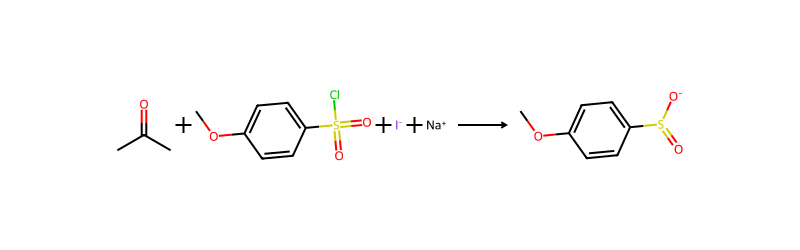

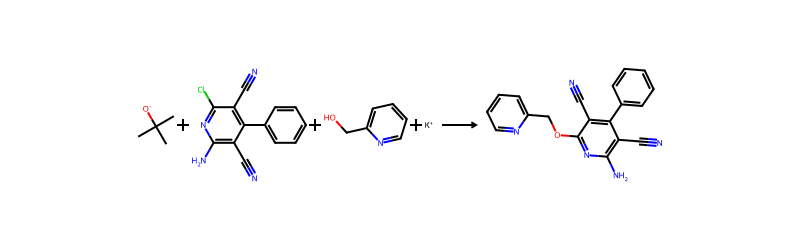

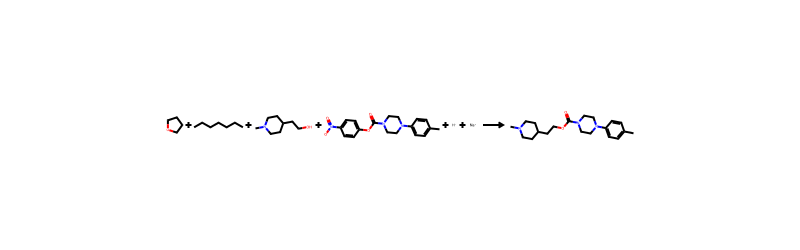

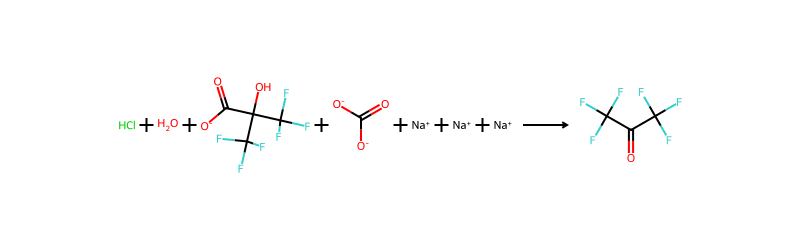

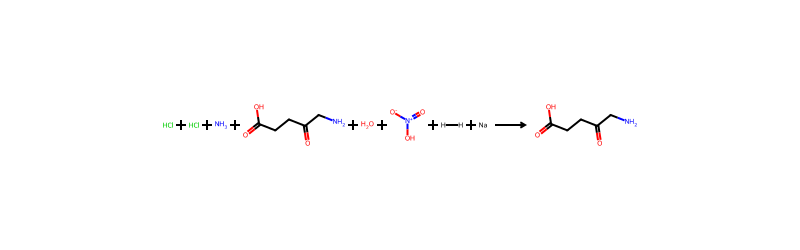

In [34]:
# Cell 22: Enhanced Reaction Drawing

def draw_reaction_comparison(precursors: str, predicted: str, expected: str,
                             title: str = "Reaction Comparison") -> None:
    """
    Draw predicted vs expected reaction products side by side.

    Args:
        precursors: SMILES of reactants
        predicted: Predicted product SMILES
        expected: Ground truth product SMILES
        title: Display title
    """
    from IPython.display import display, HTML

    pred_canonical = canonicalize_smiles(predicted)
    exp_canonical = canonicalize_smiles(expected)
    is_correct = pred_canonical == exp_canonical

    status_color = GOMES_COLORS['success'] if is_correct else GOMES_COLORS['coral']
    status_text = "CORRECT" if is_correct else "INCORRECT"

    html = f"""
    <div style="border: 2px solid {status_color}; padding: 15px; margin: 10px 0; border-radius: 8px;">
        <h3 style="color: {GOMES_COLORS['navy']};">{title}</h3>
        <p><strong>Status:</strong> <span style="color: {status_color}; font-weight: bold;">{status_text}</span></p>
        <p><strong>Reactants:</strong> <code>{precursors}</code></p>
        <p><strong>Predicted:</strong> <code>{predicted}</code></p>
        <p><strong>Expected:</strong> <code>{expected}</code></p>
    </div>
    """
    display(HTML(html))

    # Draw the predicted reaction
    rxn_smiles = f"{precursors}>>{predicted}"
    try:
        display(SVG(draw_chemical_reaction(rxn_smiles)))
    except:
        print("(Could not render reaction)")

# Show some examples from our evaluation
print("Sample Predictions from Evaluation")
print("=" * 50)

# Show correct predictions
correct_samples = eval_results[eval_results['rank'] == 1].head(3)
for _, row in correct_samples.iterrows():
    draw_reaction_comparison(
        row['precursors'],
        row['pred_1'],
        row['target_canonical'],
        "Correct Prediction"
    )

# Show incorrect predictions
incorrect_samples = eval_results[eval_results['rank'] == 0].head(2)
for _, row in incorrect_samples.iterrows():
    draw_reaction_comparison(
        row['precursors'],
        row['pred_1'],
        row['target_canonical'],
        "Incorrect Prediction"
    )

<a id='4.2'></a>
### 4.2 Error Analysis and Debugging

Understanding why predictions fail is crucial for improving models and understanding their limitations.

In [35]:
# Cell 23: Error Analysis

def analyze_prediction_errors(results_df: pd.DataFrame) -> Dict:
    """
    Analyze types of prediction errors.

    Categories:
    - Invalid SMILES: Model output couldn't be parsed
    - Wrong product: Valid SMILES but incorrect
    - Partial match: Correct in later predictions (Top-2 to Top-5)

    Args:
        results_df: DataFrame from evaluate_predictions

    Returns:
        Dictionary with error statistics
    """
    n_total = len(results_df)

    # Categorize errors
    correct_top1 = (results_df['rank'] == 1).sum()
    correct_top5 = (results_df['rank'] > 0).sum()
    invalid_smiles = (~results_df['pred_1_valid']).sum()
    wrong_but_valid = (results_df['rank'] == 0) & (results_df['pred_1_valid'])

    analysis = {
        'total_reactions': n_total,
        'correct_top1': correct_top1,
        'correct_top1_pct': correct_top1 / n_total * 100,
        'correct_top5': correct_top5,
        'correct_top5_pct': correct_top5 / n_total * 100,
        'invalid_smiles': invalid_smiles,
        'invalid_smiles_pct': invalid_smiles / n_total * 100,
        'wrong_but_valid': wrong_but_valid.sum(),
        'wrong_but_valid_pct': wrong_but_valid.sum() / n_total * 100,
    }

    return analysis

# Run error analysis
error_analysis = analyze_prediction_errors(eval_results)

print("Error Analysis")
print("=" * 50)
print(f"Total reactions evaluated: {error_analysis['total_reactions']}")
print(f"")
print(f"Correct (Top-1): {error_analysis['correct_top1']} ({error_analysis['correct_top1_pct']:.1f}%)")
print(f"Correct (Top-5): {error_analysis['correct_top5']} ({error_analysis['correct_top5_pct']:.1f}%)")
print(f"Invalid SMILES: {error_analysis['invalid_smiles']} ({error_analysis['invalid_smiles_pct']:.1f}%)")
print(f"Wrong but valid: {error_analysis['wrong_but_valid']} ({error_analysis['wrong_but_valid_pct']:.1f}%)")

Error Analysis
Total reactions evaluated: 100

Correct (Top-1): 95 (95.0%)
Correct (Top-5): 97 (97.0%)
Invalid SMILES: 0 (0.0%)
Wrong but valid: 3 (3.0%)


In [36]:
# Cell 24: Common Failure Patterns

print("""
Common Failure Patterns in Reaction Prediction
===============================================

1. STEREOCHEMISTRY ERRORS
   - Model predicts correct connectivity but wrong stereochemistry
   - Often seen in reactions involving chiral centers
   - The USPTO dataset lacks stereochemistry, so models may struggle

2. REGIOSELECTIVITY ERRORS
   - Model predicts reaction at wrong position on molecule
   - Common for aromatic substitution reactions
   - Example: ortho vs para product in electrophilic substitution

3. INCOMPLETE REACTIONS
   - Model predicts only partial transformation
   - May miss side products or byproducts
   - Common for multi-step reactions treated as single step

4. OVER-GENERALIZATION
   - Model predicts common reaction type inappropriately
   - May suggest Suzuki coupling when conditions don't support it
   - Result of training data bias

5. INVALID SMILES
   - Model generates syntactically invalid output
   - Often happens with very long molecules
   - May indicate out-of-distribution inputs

Debugging Tips:
   - Always validate output SMILES with RDKit
   - Check if reactants contain unusual functional groups
   - Consider whether reaction type was in training data
   - Use beam search (multiple predictions) to see alternatives
""")


Common Failure Patterns in Reaction Prediction

1. STEREOCHEMISTRY ERRORS
   - Model predicts correct connectivity but wrong stereochemistry
   - Often seen in reactions involving chiral centers
   - The USPTO dataset lacks stereochemistry, so models may struggle

2. REGIOSELECTIVITY ERRORS
   - Model predicts reaction at wrong position on molecule
   - Common for aromatic substitution reactions
   - Example: ortho vs para product in electrophilic substitution

3. INCOMPLETE REACTIONS
   - Model predicts only partial transformation
   - May miss side products or byproducts
   - Common for multi-step reactions treated as single step

4. OVER-GENERALIZATION
   - Model predicts common reaction type inappropriately
   - May suggest Suzuki coupling when conditions don't support it
   - Result of training data bias

5. INVALID SMILES
   - Model generates syntactically invalid output
   - Often happens with very long molecules
   - May indicate out-of-distribution inputs

Debugging Tips:
   

---

<a id='appendix-a'></a>
## Appendix A: Legacy OpenNMT-py Approach (Reference Only)

The original 2022 notebook used OpenNMT-py for training Molecular Transformers. While this approach is now deprecated, understanding the architecture is still valuable.

**Why OpenNMT-py is no longer recommended:**

1. **Maintenance Mode**: As of July 2024, OpenNMT-py is no longer actively developed. The successor project is [Eole](https://github.com/eole-nlp/eole).

2. **Dependency Issues**: The `pyonmttok` tokenizer doesn't support Python 3.12 (Google Colab's current version).

3. **Better Alternatives**: HuggingFace Transformers offers better ecosystem integration, more models, and active development.

For historical reference, the key OpenNMT-py commands were:

```bash
# Build vocabulary
onmt_build_vocab -config config.yaml -n_sample -1

# Train model
onmt_train -config config.yaml -seed 42 -gpu_ranks 0 ...

# Translate (predict)
onmt_translate -model model.pt -src test_src.txt -output predictions.txt
```

<a id='appendix-b'></a>
## Appendix B: Publications and Resources

### Core Papers

**Molecular Transformer:**
- Schwaller, P. et al. "Molecular Transformer: A Model for Uncertainty-Calibrated Chemical Reaction Prediction" *ACS Central Science* (2019) [Link](https://pubs.acs.org/doi/10.1021/acscentsci.9b00576)

**ReactionT5:**
- Sagawa, T. & Kojima, R. "ReactionT5: a pre-trained transformer model for accurate chemical reaction prediction with limited data" *Journal of Cheminformatics* (2025) [Link](https://doi.org/10.1186/s13321-025-01075-4)

**RXNMapper:**
- Schwaller, P. et al. "Extraction of organic chemistry grammar from unsupervised learning of chemical reactions" *Science Advances* (2021) [Link](https://www.science.org/doi/10.1126/sciadv.abe4166)

### Additional Resources

**Tutorials and Blogs:**
- [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) - Visual explanation of transformer architecture
- [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) - Code walkthrough

**Tools and Datasets:**
- [Open Reaction Database (ORD)](https://open-reaction-database.org/) - Large-scale reaction data
- [IBM RXN for Chemistry](https://rxn.res.ibm.com) - Production API
- [RDKit](https://www.rdkit.org/) - Cheminformatics toolkit

**Review Papers:**
- Schwaller, P. "Machine Intelligence for Chemical Reaction Space" *WIREs Computational Molecular Science* (2022) [Link](https://wires.onlinelibrary.wiley.com/doi/full/10.1002/wcms.1604)

In [37]:
# Cell 25: Session Summary

print("""
================================================================================
                    SESSION SUMMARY: REACTION PREDICTION
================================================================================

Key Takeaways:

1. SMILES as Chemical Language
   - Molecules and reactions can be represented as text strings
   - Canonicalization ensures consistent representation
   - Atom-wise tokenization preserves chemical meaning

2. Transformer Models for Chemistry
   - Treat reaction prediction as sequence-to-sequence translation
   - Self-attention captures long-range dependencies in molecules
   - Pre-training on large datasets enables transfer learning

3. ReactionT5v2 Advantages
   - Pre-trained on diverse Open Reaction Database
   - Easy fine-tuning for specialized applications
   - Works out-of-the-box on Google Colab

4. Practical Considerations
   - Always validate output SMILES
   - Use beam search for multiple predictions
   - Data augmentation improves generalization
   - Consider API services for production use

Next Steps:
   - Try fine-tuning on your own reaction dataset
   - Explore retrosynthesis for synthesis planning
   - Integrate with reaction fingerprints (RXNFP/DRFP)
   - Investigate yield prediction capabilities

================================================================================
""")


                    SESSION SUMMARY: REACTION PREDICTION

Key Takeaways:

1. SMILES as Chemical Language
   - Molecules and reactions can be represented as text strings
   - Canonicalization ensures consistent representation
   - Atom-wise tokenization preserves chemical meaning

2. Transformer Models for Chemistry
   - Treat reaction prediction as sequence-to-sequence translation
   - Self-attention captures long-range dependencies in molecules
   - Pre-training on large datasets enables transfer learning

3. ReactionT5v2 Advantages
   - Pre-trained on diverse Open Reaction Database
   - Easy fine-tuning for specialized applications
   - Works out-of-the-box on Google Colab

4. Practical Considerations
   - Always validate output SMILES
   - Use beam search for multiple predictions
   - Data augmentation improves generalization
   - Consider API services for production use

Next Steps:
   - Try fine-tuning on your own reaction dataset
   - Explore retrosynthesis for synthesis plannin

In [38]:
# Cell 26: Clean up GPU memory
import gc

# Clean up models to free memory
if 'forward_predictor' in dir():
    del forward_predictor
if 'retro_predictor' in dir():
    del retro_predictor

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory cleared. Current usage: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
else:
    print("Session complete.")

GPU memory cleared. Current usage: 4.03 GB
